# Análisis de Datos

# Abrir datos necesarios

## Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score

from sklearn.feature_selection import RFE

## Datos

### Subir .txt

In [3]:
#Cambiar dependiendo del usuario
data = np.loadtxt("/Users/levguzman/Documents/IDM_Life/4to/Modelación del aprendizaje con inteligencia artificial/Proyecto1/activity_data.txt")

In [4]:
#data = np.loadtxt("..\\notebooks\\activity_data.txt")

### Arreglar base de datos

In [5]:
data = pd.DataFrame(data)

clase_dict = {
    1: 'Nothing',
    2: 'Despegue',
    3: 'Aterrizaje',
    4: 'Vuelo_estable',
    5: 'Turbulencia',
    6: 'Choque',
    7: 'Truco',
    8: 'Patrones_de_espera',
    9: 'En_pista'
}

if data[0].isnull().any():
    print("Hay valores NaN en la primera columna.")

data[0] = data[0].astype(int).map(clase_dict)

senales = ["accX", "accY", "accZ",
           "lin_accX", "lin_accY", "lin_accZ",
           "gyroX", "gyroY", "gyroZ",
           "magX", "magY", "magZ",
           "gpsLat", "gpsLon"]

columnas = ["Clase"]
for i in senales:
    columnas.append(f"{i}_average")
    columnas.append(f"{i}_std")
    columnas.append(f"{i}_max")
    columnas.append(f"{i}_min")
    columnas.append(f"{i}_kurtosis")
    columnas.append(f"{i}_skew")
columnas.append("rms")

data.columns = columnas

In [6]:
print("Cantidad de datos predictores:", data.shape[0]*(data.shape[1] - 1))
print(f"Valores nulos: {data.isna().sum().sum()}")

def ver_categorias(data):
    for i in data.columns:
        if data[i].dtype not in ["float64"]:
            print()
            print("------------------")
            print(f"{i}: {len(set(data[i]))}")
            print(set(data[i]))

ver_categorias(data)

Cantidad de datos predictores: 45900
Valores nulos: 0

------------------
Clase: 9
{'Vuelo_estable', 'Turbulencia', 'Despegue', 'Truco', 'Patrones_de_espera', 'Choque', 'En_pista', 'Aterrizaje', 'Nothing'}


In [7]:
columnas.remove("Clase")
x = data[columnas].to_numpy()
y = data["Clase"].to_numpy()


# Procesamiento

1. Procese los datos de tal manera que cada observación tenga al menos 30 variables o características. La forma de procesar lo datos depende de las señales adquiridas.

---

esto se realiza en el archivo `trial_acquisition.py`

# Evaluación de Clasificadores

2. Con las características calculadas, evalúa el rendimiento de los modelos de clasificación SVM, SVM de base radial, LDA, K-NN, y MLP (de al menos 2 capas). Calcule tanto la exactitud, la precisión por clase y la sensibilidad por clase para cada uno de los modelos.

3. Seleccione cinco modelos de clasificación no vistos en clase, y evalúelos con sus conjuntos de datos. Calcule tanto la exactitud, la precisión por clase y la sensibilidad por clase para cada uno de los modelos.

### Funciones

Hacer cross validation

In [8]:
# Hacer Cross validation dependiendo del modelo; se resume mucho el código ****
def evaluate_stratified_shuffle_split(X, y, modelo_kernel, train_size=0.8, n_splits=5,
                                          random_state=1234, getter=False):
    sss = StratifiedShuffleSplit(
        n_splits=n_splits,
        train_size=train_size,
        #random_state=random_state
    )
    classes = np.unique(y)
    num_classes = len(classes)
    acc = 0
    recall = np.zeros(num_classes)
    precision = np.zeros(num_classes)

    cv_y_test = []
    cv_y_pred = [] 

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

#-----------------------------Modelos Utilizados ----------------------------------
        if modelo_kernel == "SVC_linear":
            clf = SVC(kernel='linear', class_weight='balanced')
        elif modelo_kernel == "SVC_rbf":
            clf = SVC(kernel='rbf', class_weight='balanced')
        elif modelo_kernel == "LinearDiscriminantAnalysis":   
            clf = LinearDiscriminantAnalysis()
        elif modelo_kernel == "KNeighborsClassifier":    
            clf = KNeighborsClassifier(n_neighbors=3)
        elif modelo_kernel == "MLPClassifier":  
            clf = MLPClassifier(hidden_layer_sizes=(10,10,10,10,10,10), max_iter=10000)
        elif modelo_kernel == "SVC_poly":
            clf = SVC(kernel='poly', class_weight='balanced')
        elif modelo_kernel == "GaussianNB":
            clf = GaussianNB()
        elif modelo_kernel == "RandomForestClassifier": 
            clf = RandomForestClassifier(max_depth=10, random_state=1234)
        elif modelo_kernel == "AdaBoostClassifier": 
            clf = AdaBoostClassifier(n_estimators=100, random_state=1234)
        elif modelo_kernel == "GradientBoostingClassifier": 
            clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0)
#-------------------------------------------------------------------------------------
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cv_y_test.append(y_test)
        cv_y_pred.append(y_pred)
        acc += accuracy_score(y_test, y_pred)
        recall += recall_score(y_test, y_pred, average=None, labels=classes)
        precision += precision_score(y_test, y_pred, average=None, labels=classes, zero_division=0)


    acc_mean = acc / n_splits
    precision_mean = precision / n_splits
    recall_mean = recall / n_splits
    y_test_all = np.concatenate(cv_y_test)
    y_pred_all = np.concatenate(cv_y_pred)
    cm = confusion_matrix(y_test_all, y_pred_all, labels=classes)
    report = classification_report(y_test_all, y_pred_all, target_names=classes, zero_division=0)
    results = {
        'accuracy': acc_mean,
        'precision': dict(zip(classes, precision_mean)),
        'recall': dict(zip(classes, recall_mean)),
        'confusion_matrix': cm,
        'classification_report': report,
        'y_test_all': y_test_all,
        'y_pred_all': y_pred_all,
        'classes': classes
    }

    
    if getter:
        observacion = [train_size, acc_mean]
        # Agregar recall para cada clase en orden
        for cls in sorted(classes):
            observacion.append(recall_mean[np.where(classes == cls)[0][0]])
        return observacion
    else:
        print("------------------")
        print(modelo_kernel)
        print("------------------")
        print(f'Accuracy promedio: {results["accuracy"]:.4f}')
        print("------------------")
        print('Precision por clase:')
        for cls, prec in results["precision"].items():
            print(f'{cls}: {prec:.4f}')
        print("------------------")
        print('Recall por clase:')
        for cls, rec in results["recall"].items():
            print(f'{cls}: {rec:.4f}')
        print("------------------")
        print(f'Matriz de confusión:\n{results["confusion_matrix"]}')
        print("Clases:", results["classes"])
        print("------------------")
        print(f'Reporte de clasificación:\n{results["classification_report"]}')
        print("------------------")

Checar el tamaño óptimo del set de entrenamiento

In [9]:
def prueba_tamano_entrenamiento(x, y, m_k):
    datos = []
    for i in range(int(19)):
        for j in range(int(20)):
            r = evaluate_stratified_shuffle_split(x, y, train_size=((((i + 1)*5)/100)),
                                                    n_splits=5, random_state=1234 + j,
                                                    getter=True, modelo_kernel=m_k)
            datos.append(r)
            
            # VISUAL PARA LOS MODELOS QUE SE TARDAN
            if m_k == "SVC_linear" or m_k == "MLPClassifier" or m_k == "GradientBoostingClassifier":
                 print(f"i: {i}, j: {j}")


    #----------------------------- Plot ----------------------------------
    column_names = ['Tamaño_Entrenamiento', 'Exactitud']
    classes = sorted(clase_dict.values())
    column_names.extend([f'Recall_{cls}' for cls in classes])
    dato = pd.DataFrame(datos, columns=column_names)
    df_promedio = dato.groupby('Tamaño_Entrenamiento').mean().reset_index()
    plt.figure(figsize=(20, 15))
    # Lista de métricas y colores
    metricas = [('Exactitud', 'b')]
    colors = ['g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
    for cls, color in zip(classes, colors):
        metricas.append((f'Recall_{cls}', color))
    # Crear subplots en grid 4x3
    for idx, (metrica, color) in enumerate(metricas, start=1):
        plt.subplot(4, 3, idx)
        plt.plot(df_promedio['Tamaño_Entrenamiento'], df_promedio[metrica], 
                marker='o', color=color, linestyle='-', linewidth=2)
        # Extraer el nombre de la clase del nombre de la métrica
        if metrica.startswith('Recall_'):
            title = f'Recall {metrica[7:]} vs Tamaño Entrenamiento'
        else:
            title = f'{metrica} vs Tamaño Entrenamiento'
        plt.title(title, fontsize=10)
        plt.xlabel('Tamaño Entrenamiento (%)', fontsize=8)
        plt.ylabel(metrica, fontsize=8)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.ylim(0, 1)
        plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
        plt.axhline(y=0.75, color='gray', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()
#-------------------------------------------------------------------------------------

### Aplicar funciones

In [10]:
modelos_kernel = [
    "SVC_rbf",
    "LinearDiscriminantAnalysis",
    "KNeighborsClassifier",
    "SVC_poly",
    "GaussianNB",
    "RandomForestClassifier",
    "AdaBoostClassifier",
    "GradientBoostingClassifier",
    "MLPClassifier",
    "SVC_linear"
]

Checar los estadísticos con cross validation  `Stratified Shuffle Split` y `train_size = 0.8`

In [11]:
#1m20s aprox
for modelo in modelos_kernel:
    print(f"Ejecutando modelo: {modelo}")
    evaluacion = evaluate_stratified_shuffle_split(x, y, modelo_kernel=modelo, getter=False)
    print(f"Fin de Ejecución del modelo: {modelo}")
    print("#" * 50)  # Divisor 


Ejecutando modelo: SVC_rbf
------------------
SVC_rbf
------------------
Accuracy promedio: 0.5685
------------------
Precision por clase:
Aterrizaje: 0.1255
Choque: 0.5833
Despegue: 0.1500
En_pista: 0.9470
Nothing: 0.9156
Patrones_de_espera: 0.9275
Truco: 0.5949
Turbulencia: 0.9600
Vuelo_estable: 0.3017
------------------
Recall por clase:
Aterrizaje: 0.1167
Choque: 0.1000
Despegue: 0.0500
En_pista: 0.8000
Nothing: 0.9000
Patrones_de_espera: 1.0000
Truco: 0.9167
Turbulencia: 0.2333
Vuelo_estable: 1.0000
------------------
Matriz de confusión:
[[ 7  0  0  0  0  0  5  0 48]
 [30  6  0  0  0  0 21  0  3]
 [ 0  0  3  0  0  0  7  0 50]
 [ 0  3  3 48  5  0  1  0  0]
 [ 0  3  0  3 54  0  0  0  0]
 [ 0  0  0  0  0 60  0  0  0]
 [ 0  0  0  0  0  1 55  1  3]
 [ 0  0  0  0  0  4  6 14 36]
 [ 0  0  0  0  0  0  0  0 60]]
Clases: ['Aterrizaje' 'Choque' 'Despegue' 'En_pista' 'Nothing'
 'Patrones_de_espera' 'Truco' 'Turbulencia' 'Vuelo_estable']
------------------
Reporte de clasificación:
          

Sacar prueba del tamaño de entrenamiento

Ejecutando modelo: SVC_rbf


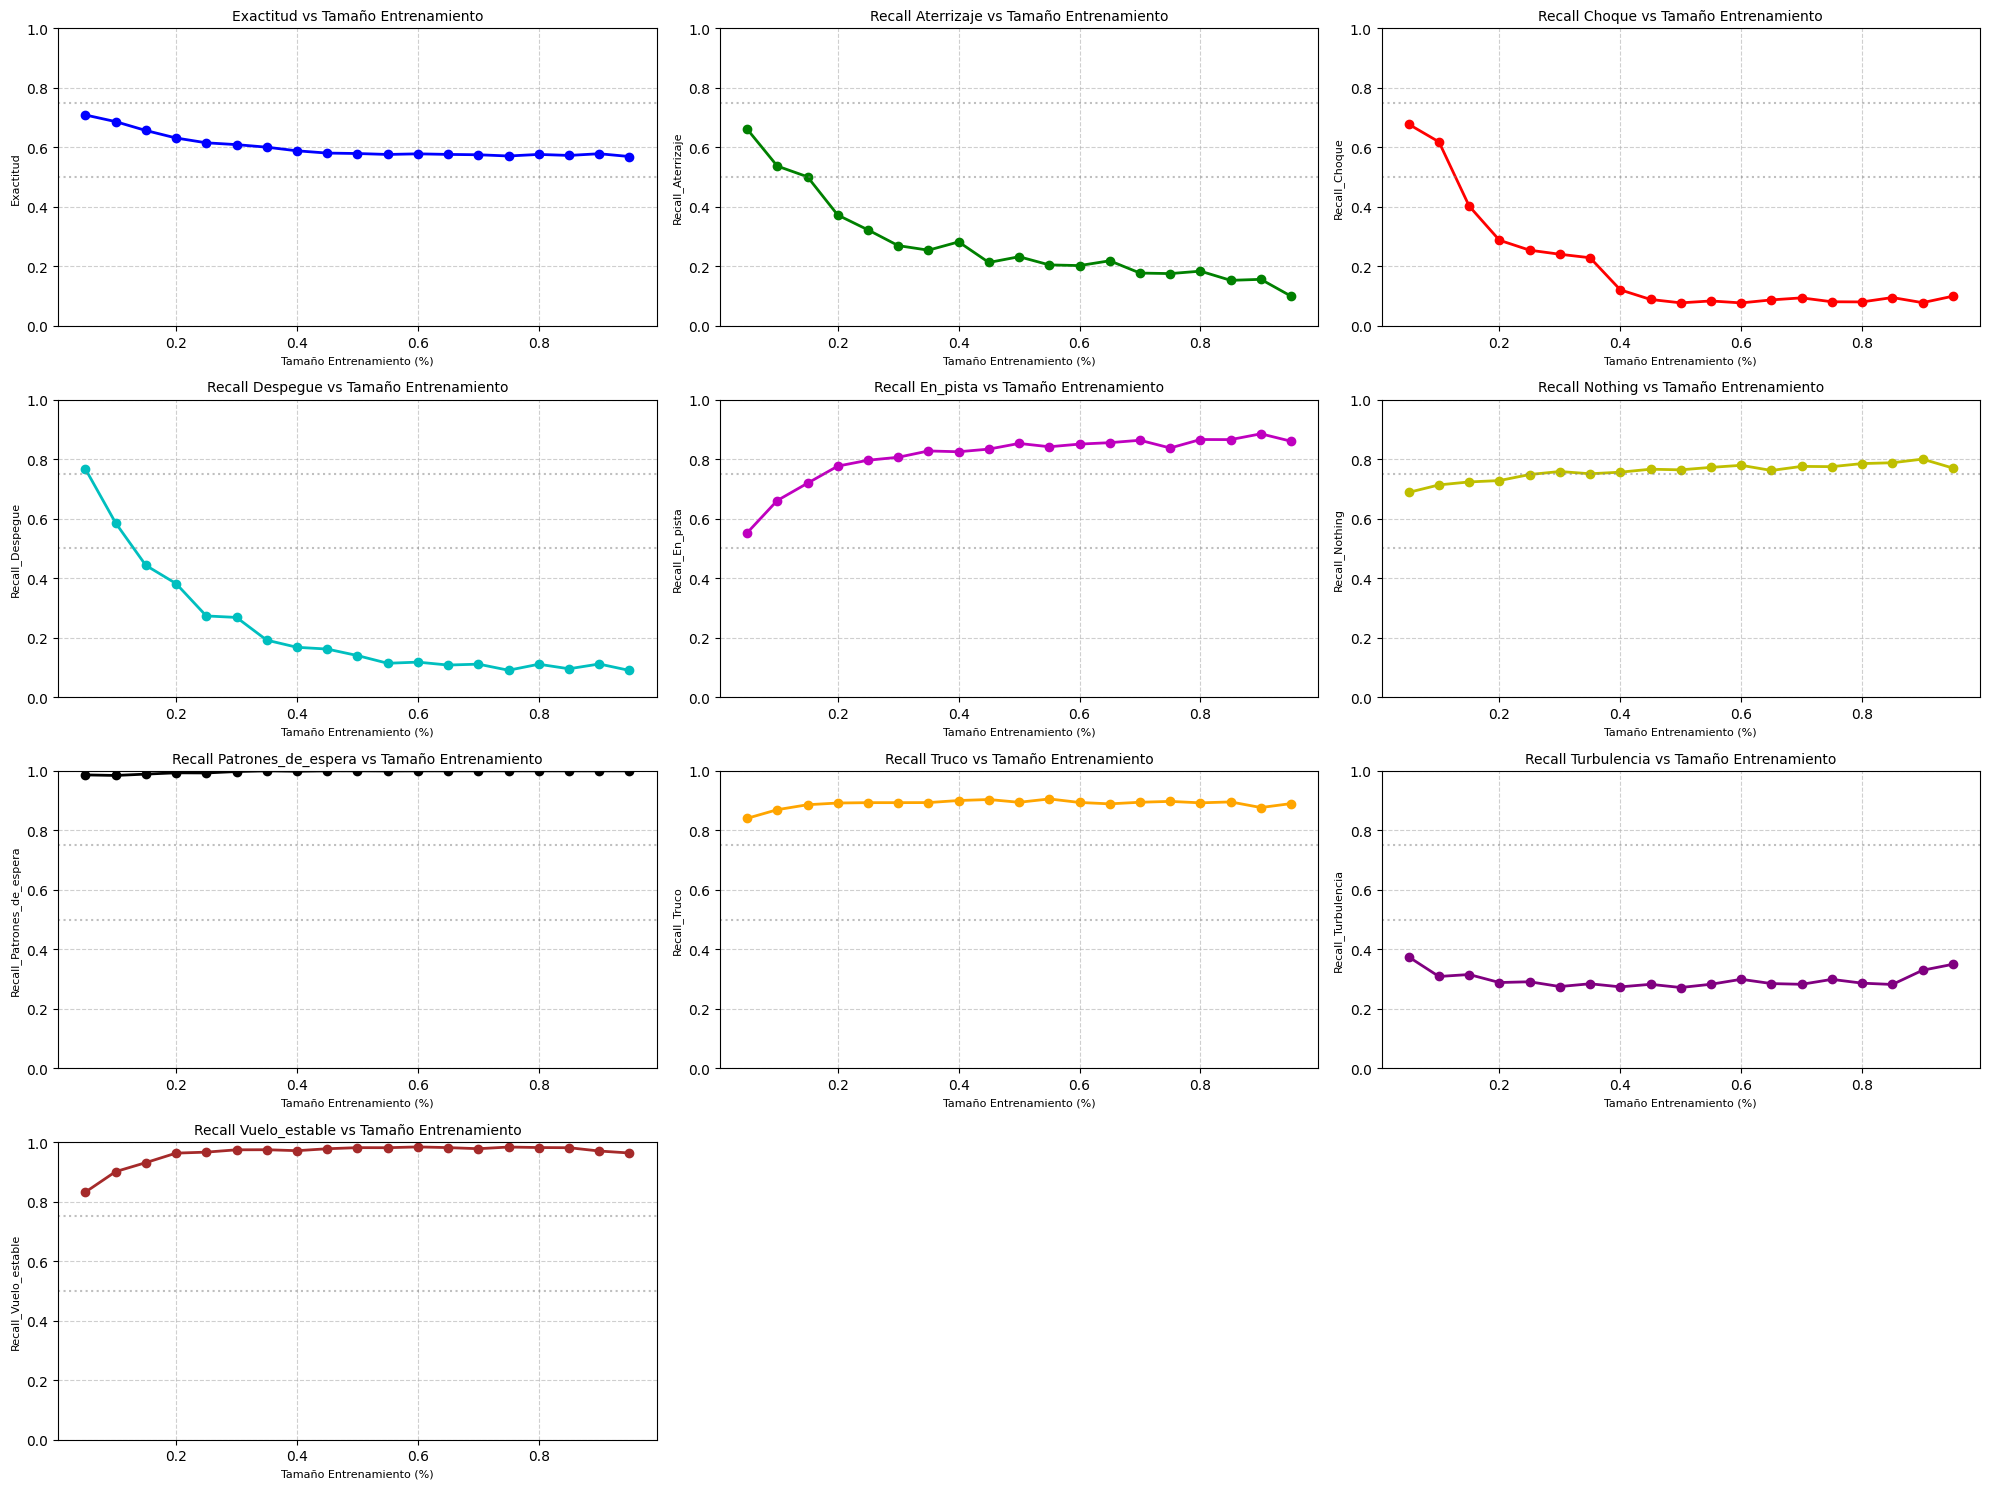

Ejecutando modelo: LinearDiscriminantAnalysis


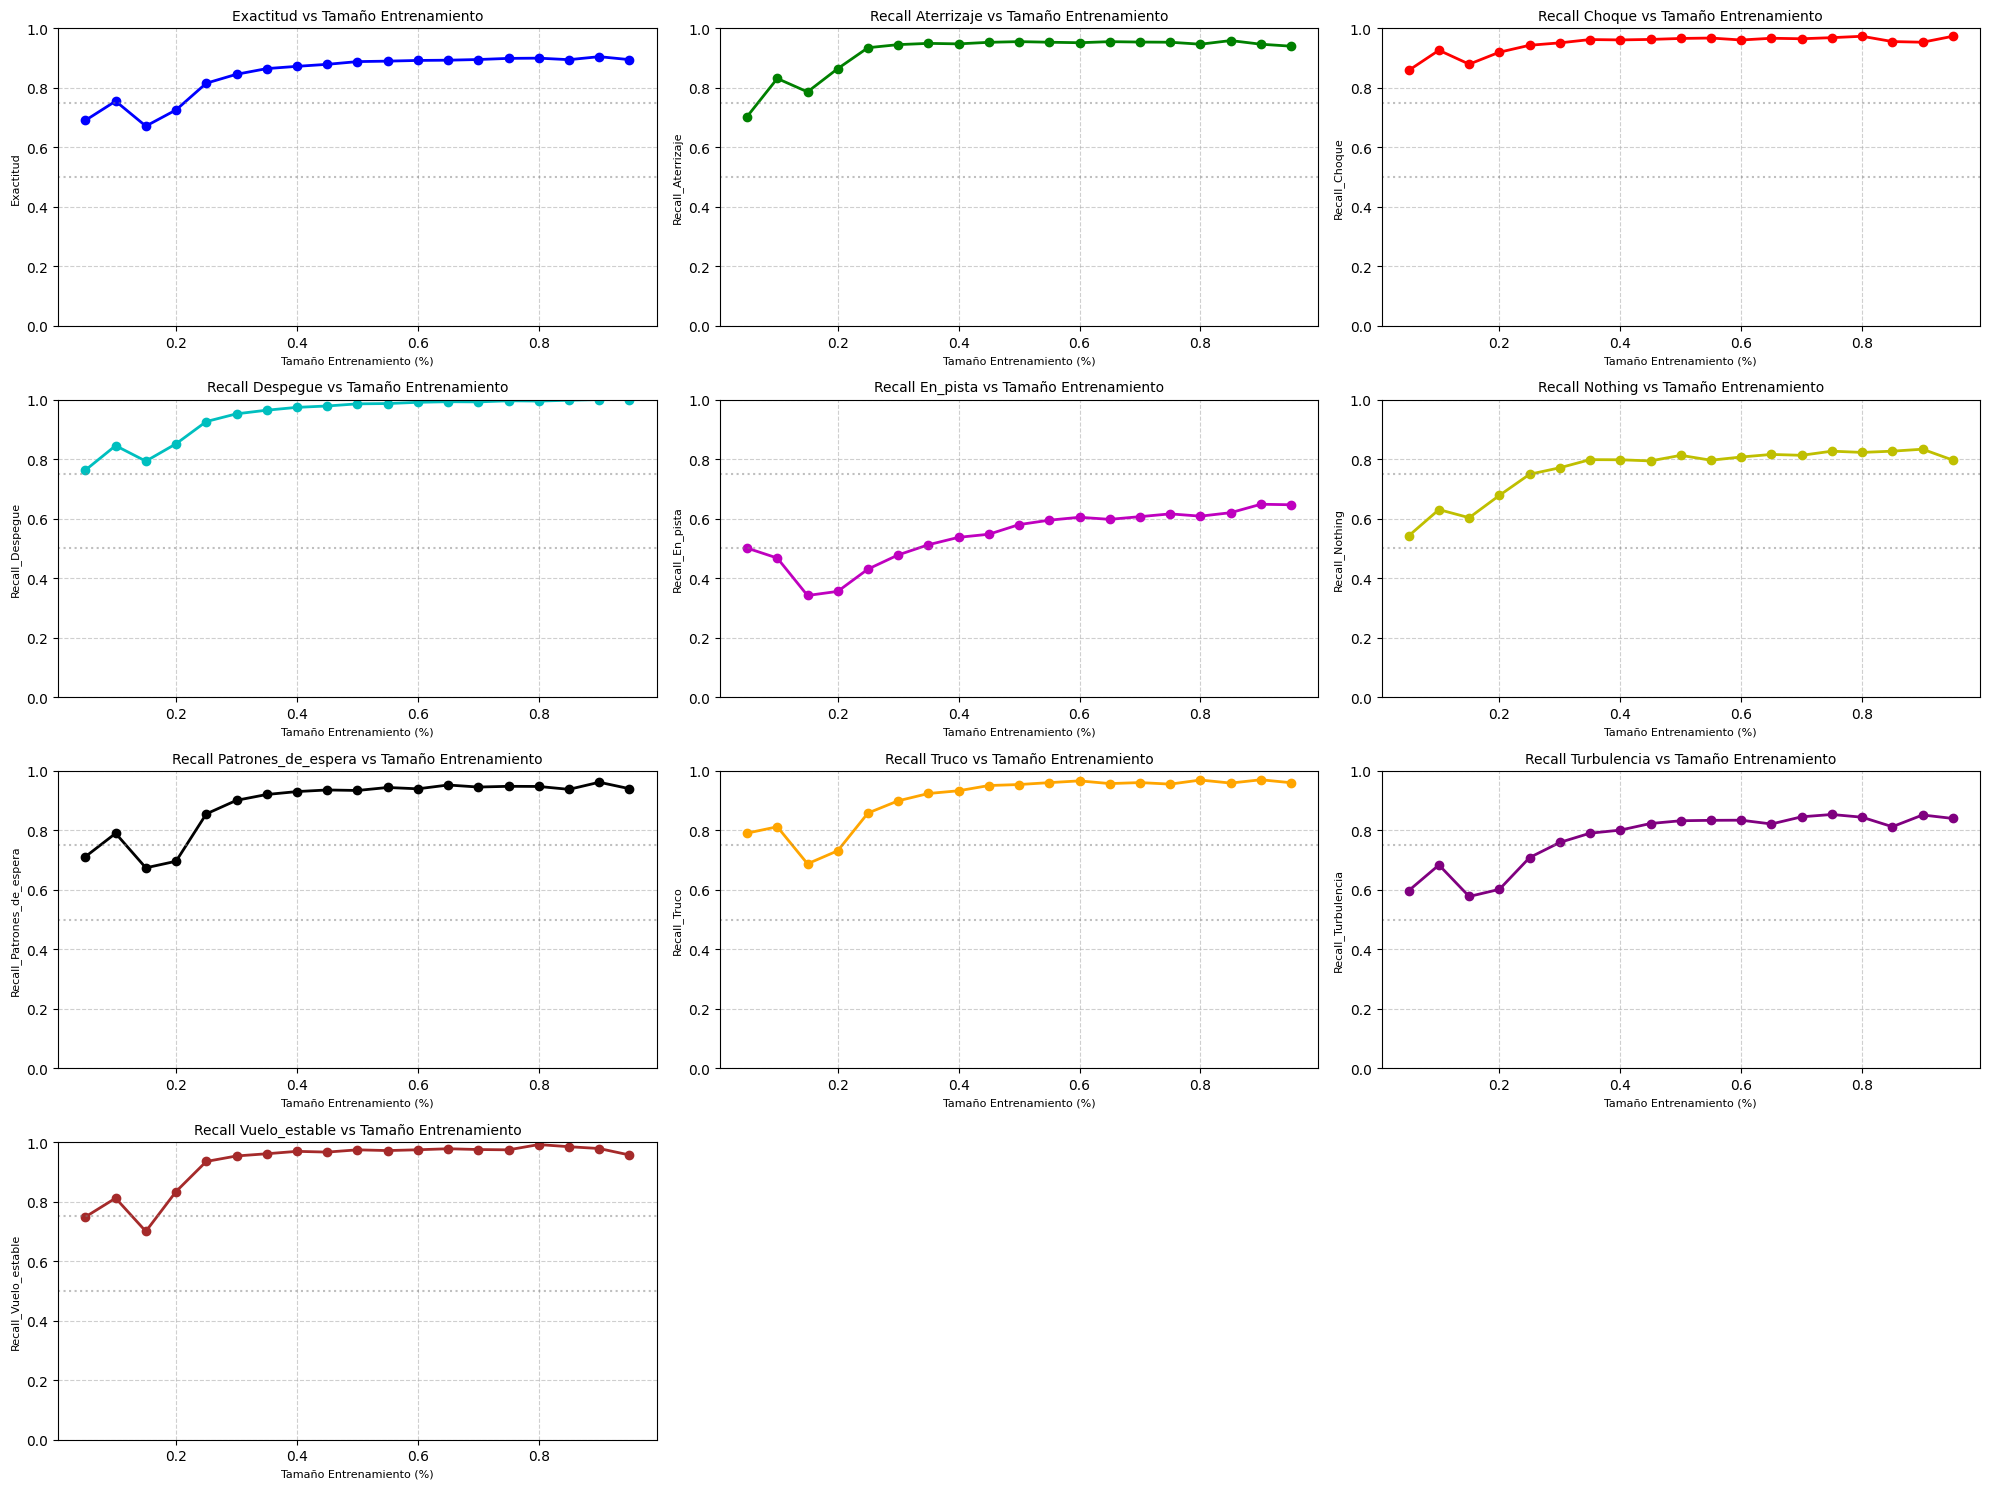

Ejecutando modelo: KNeighborsClassifier


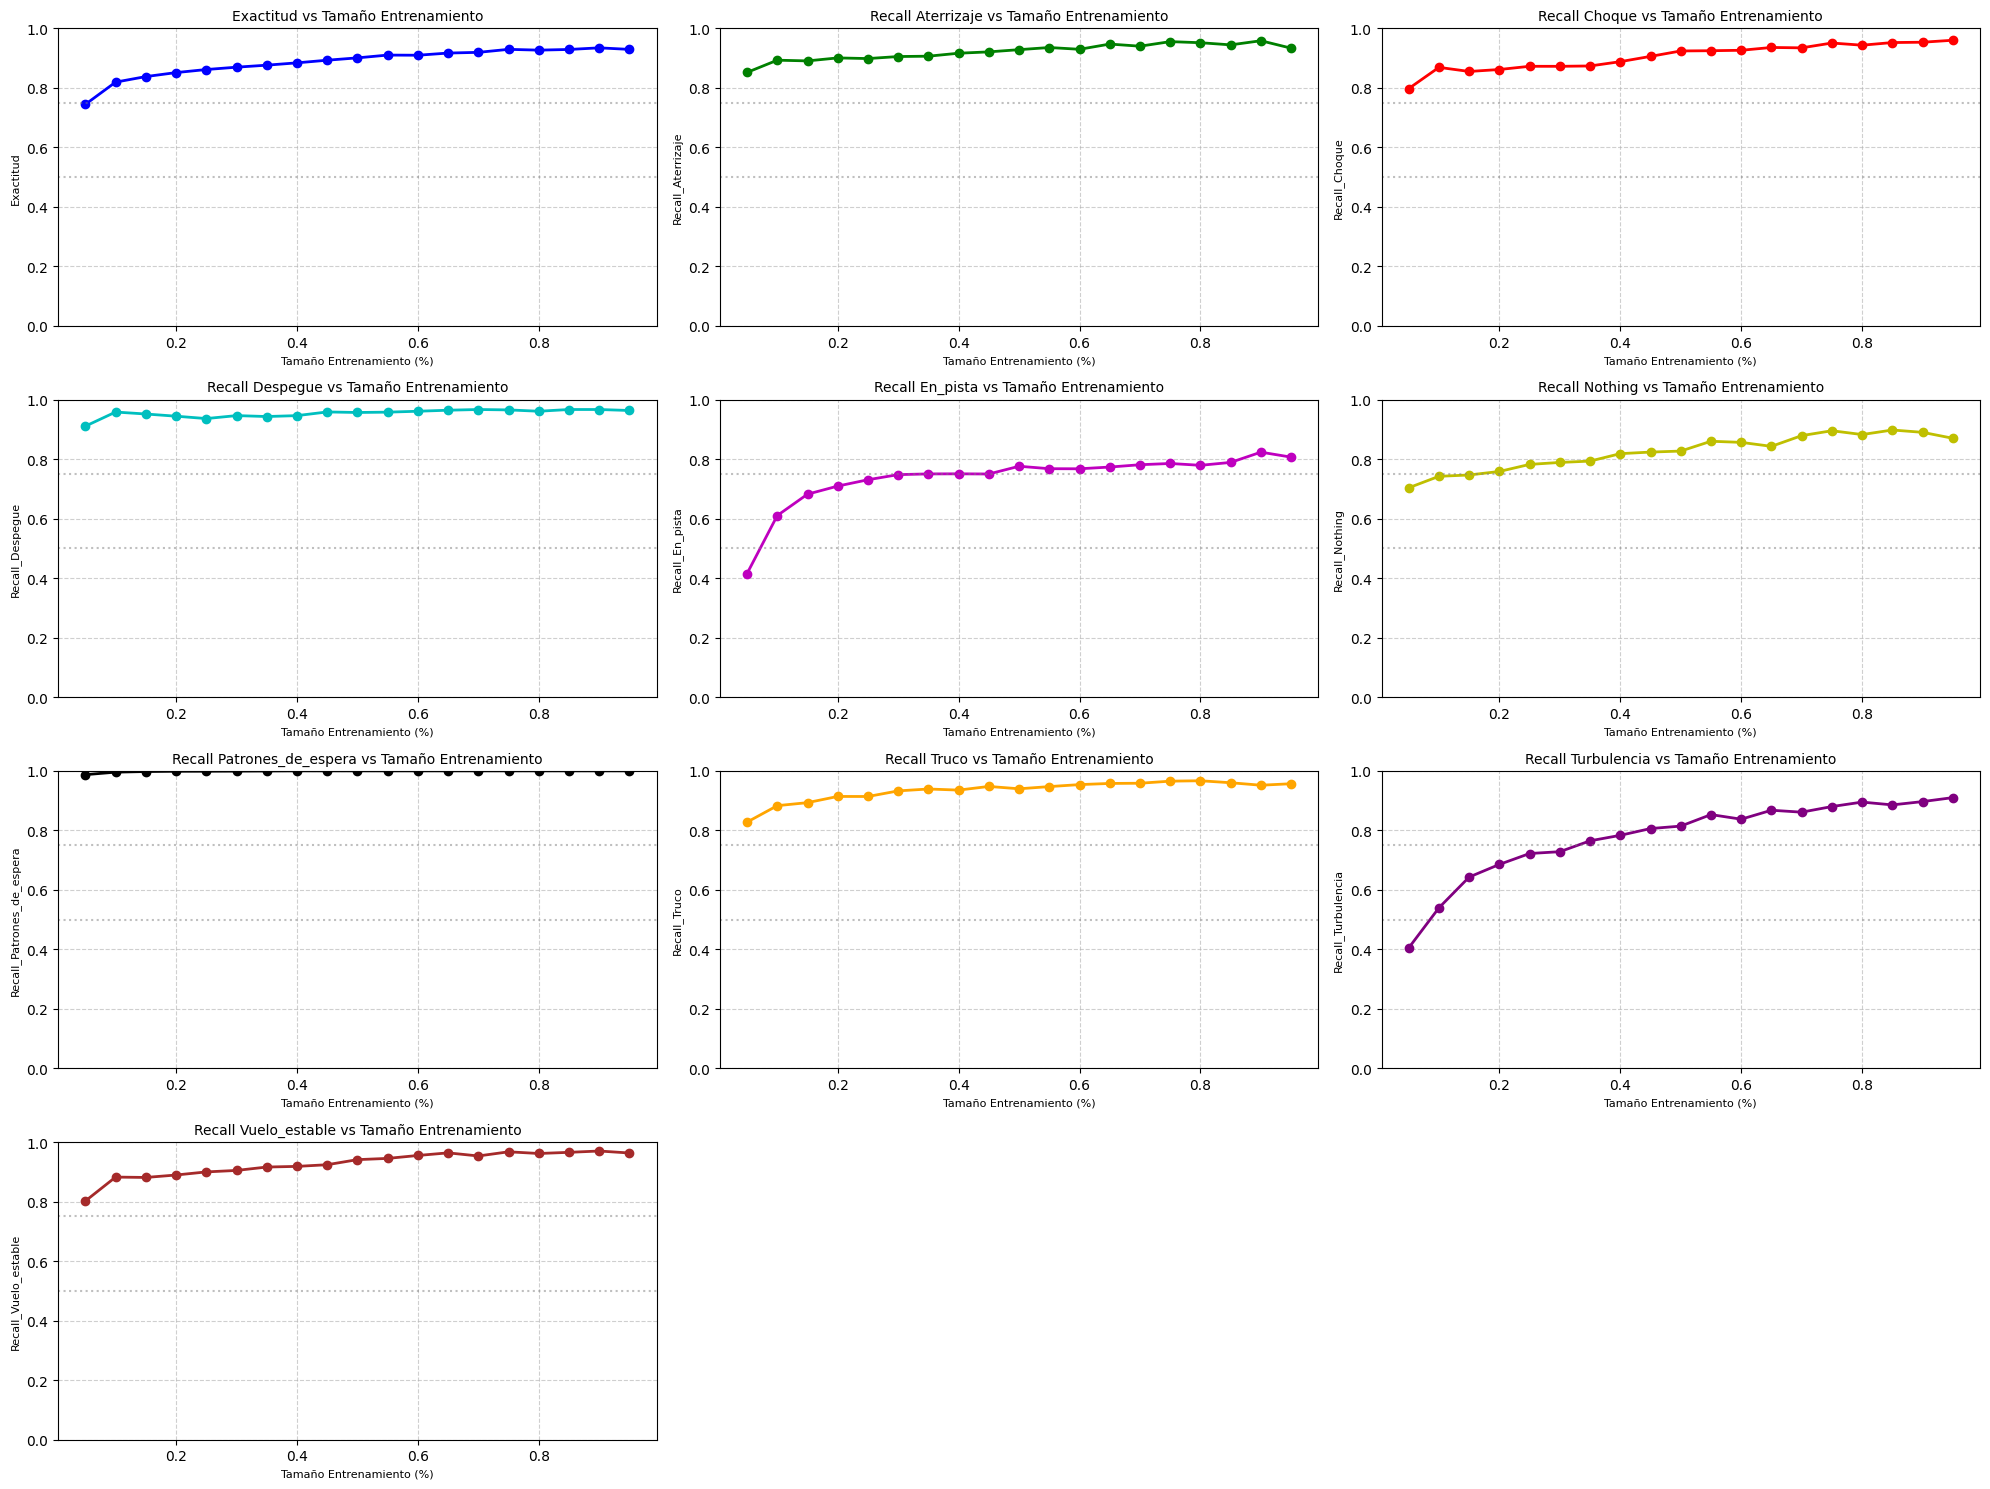

Ejecutando modelo: SVC_poly


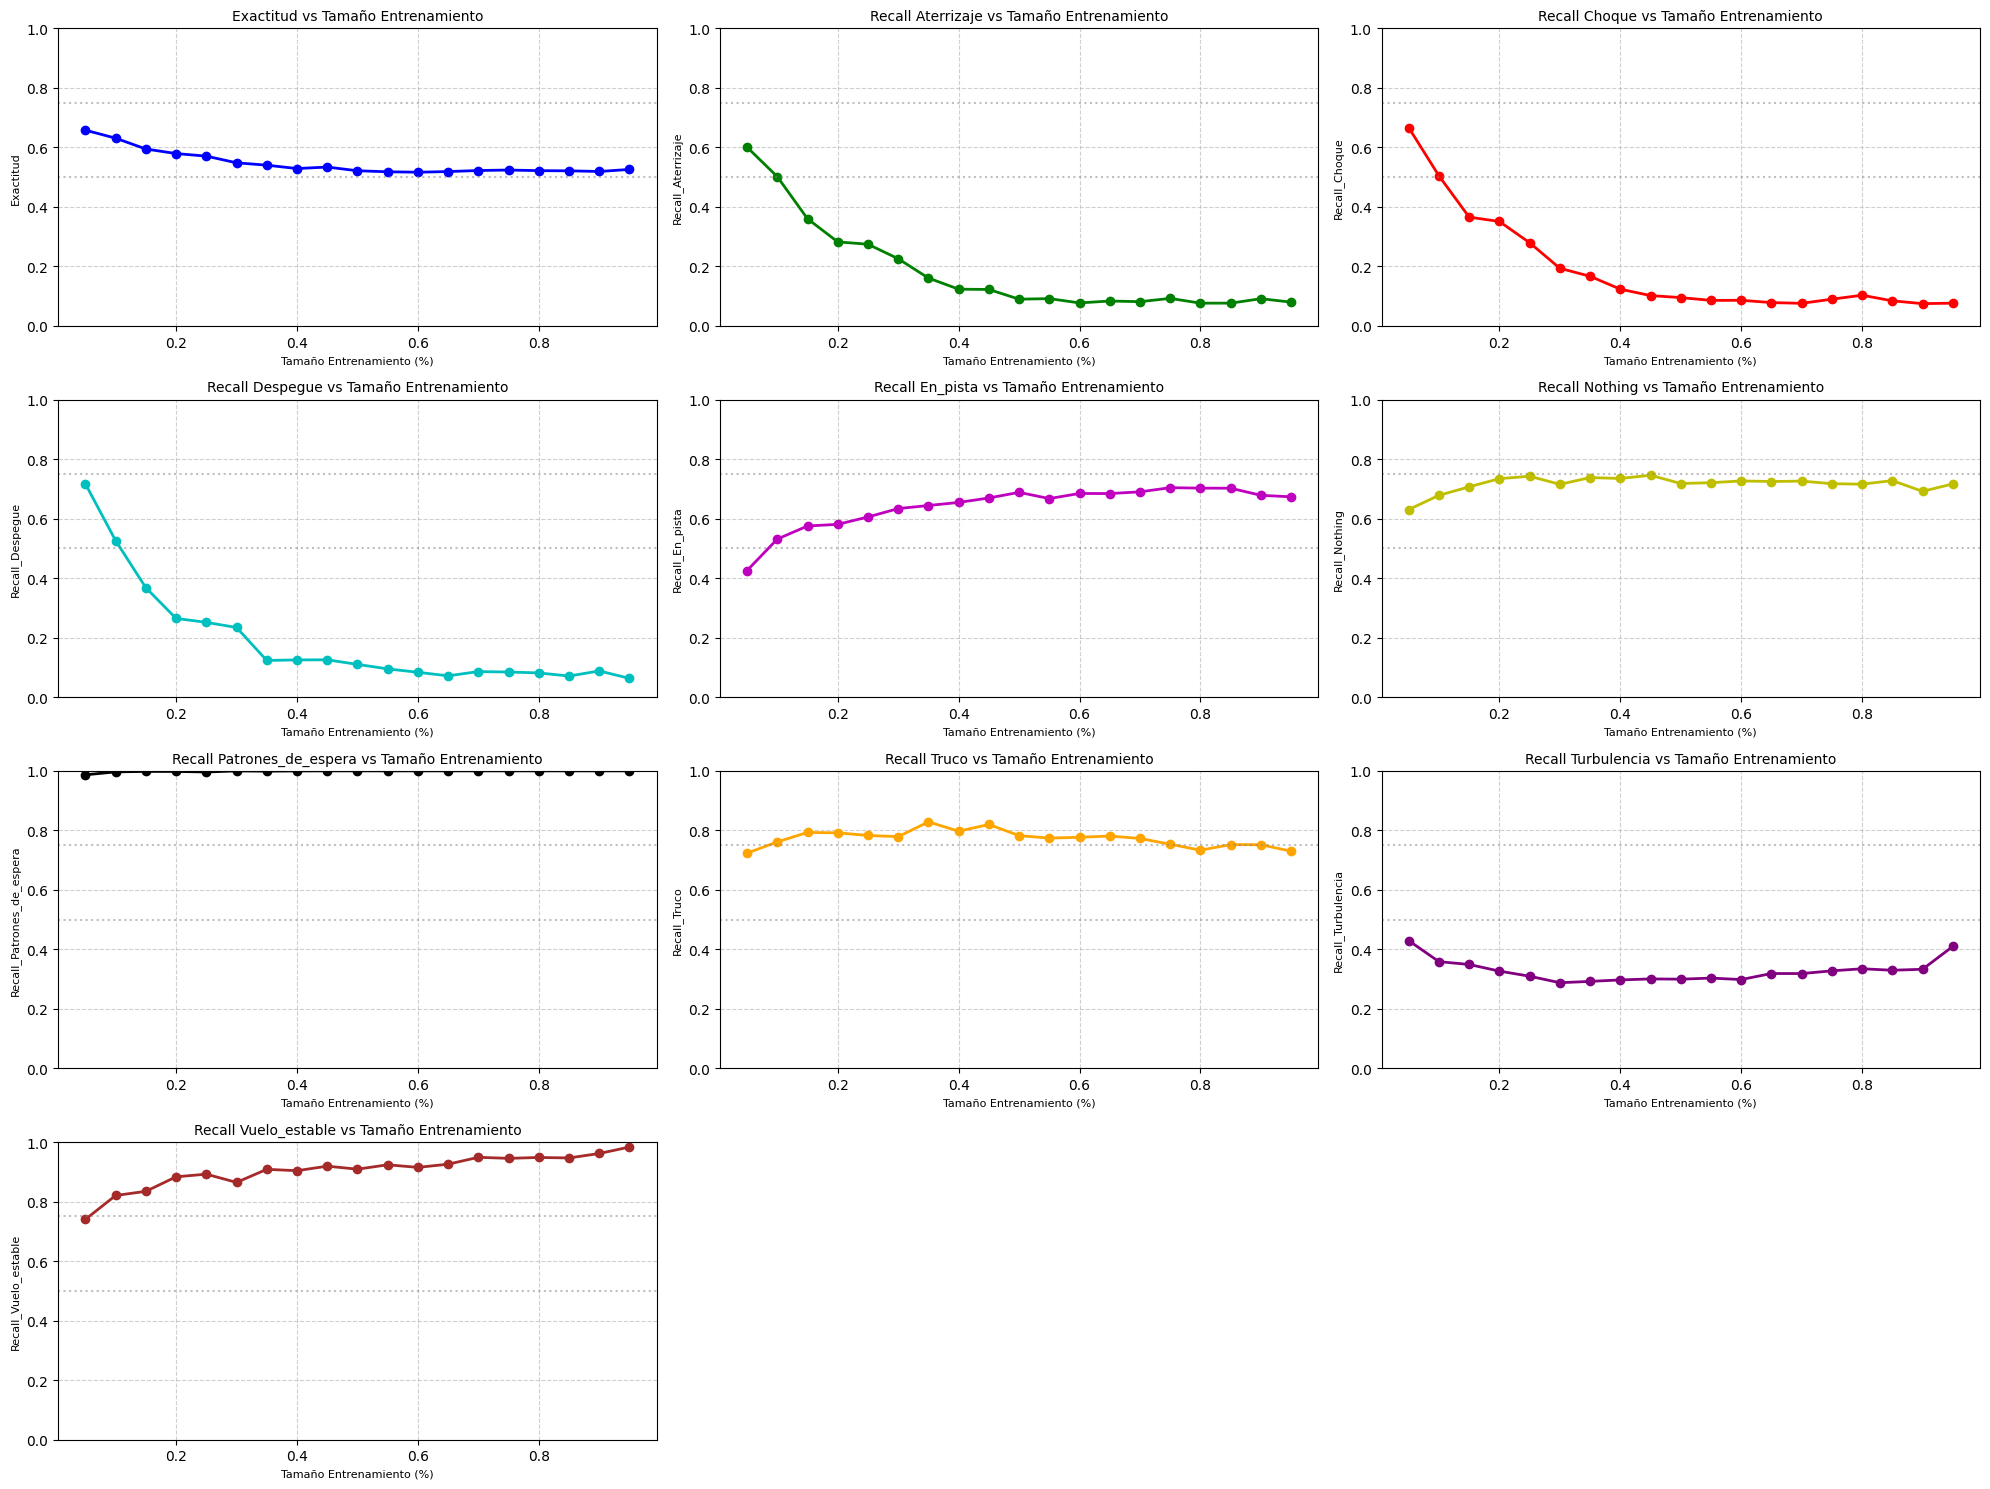

Ejecutando modelo: GaussianNB


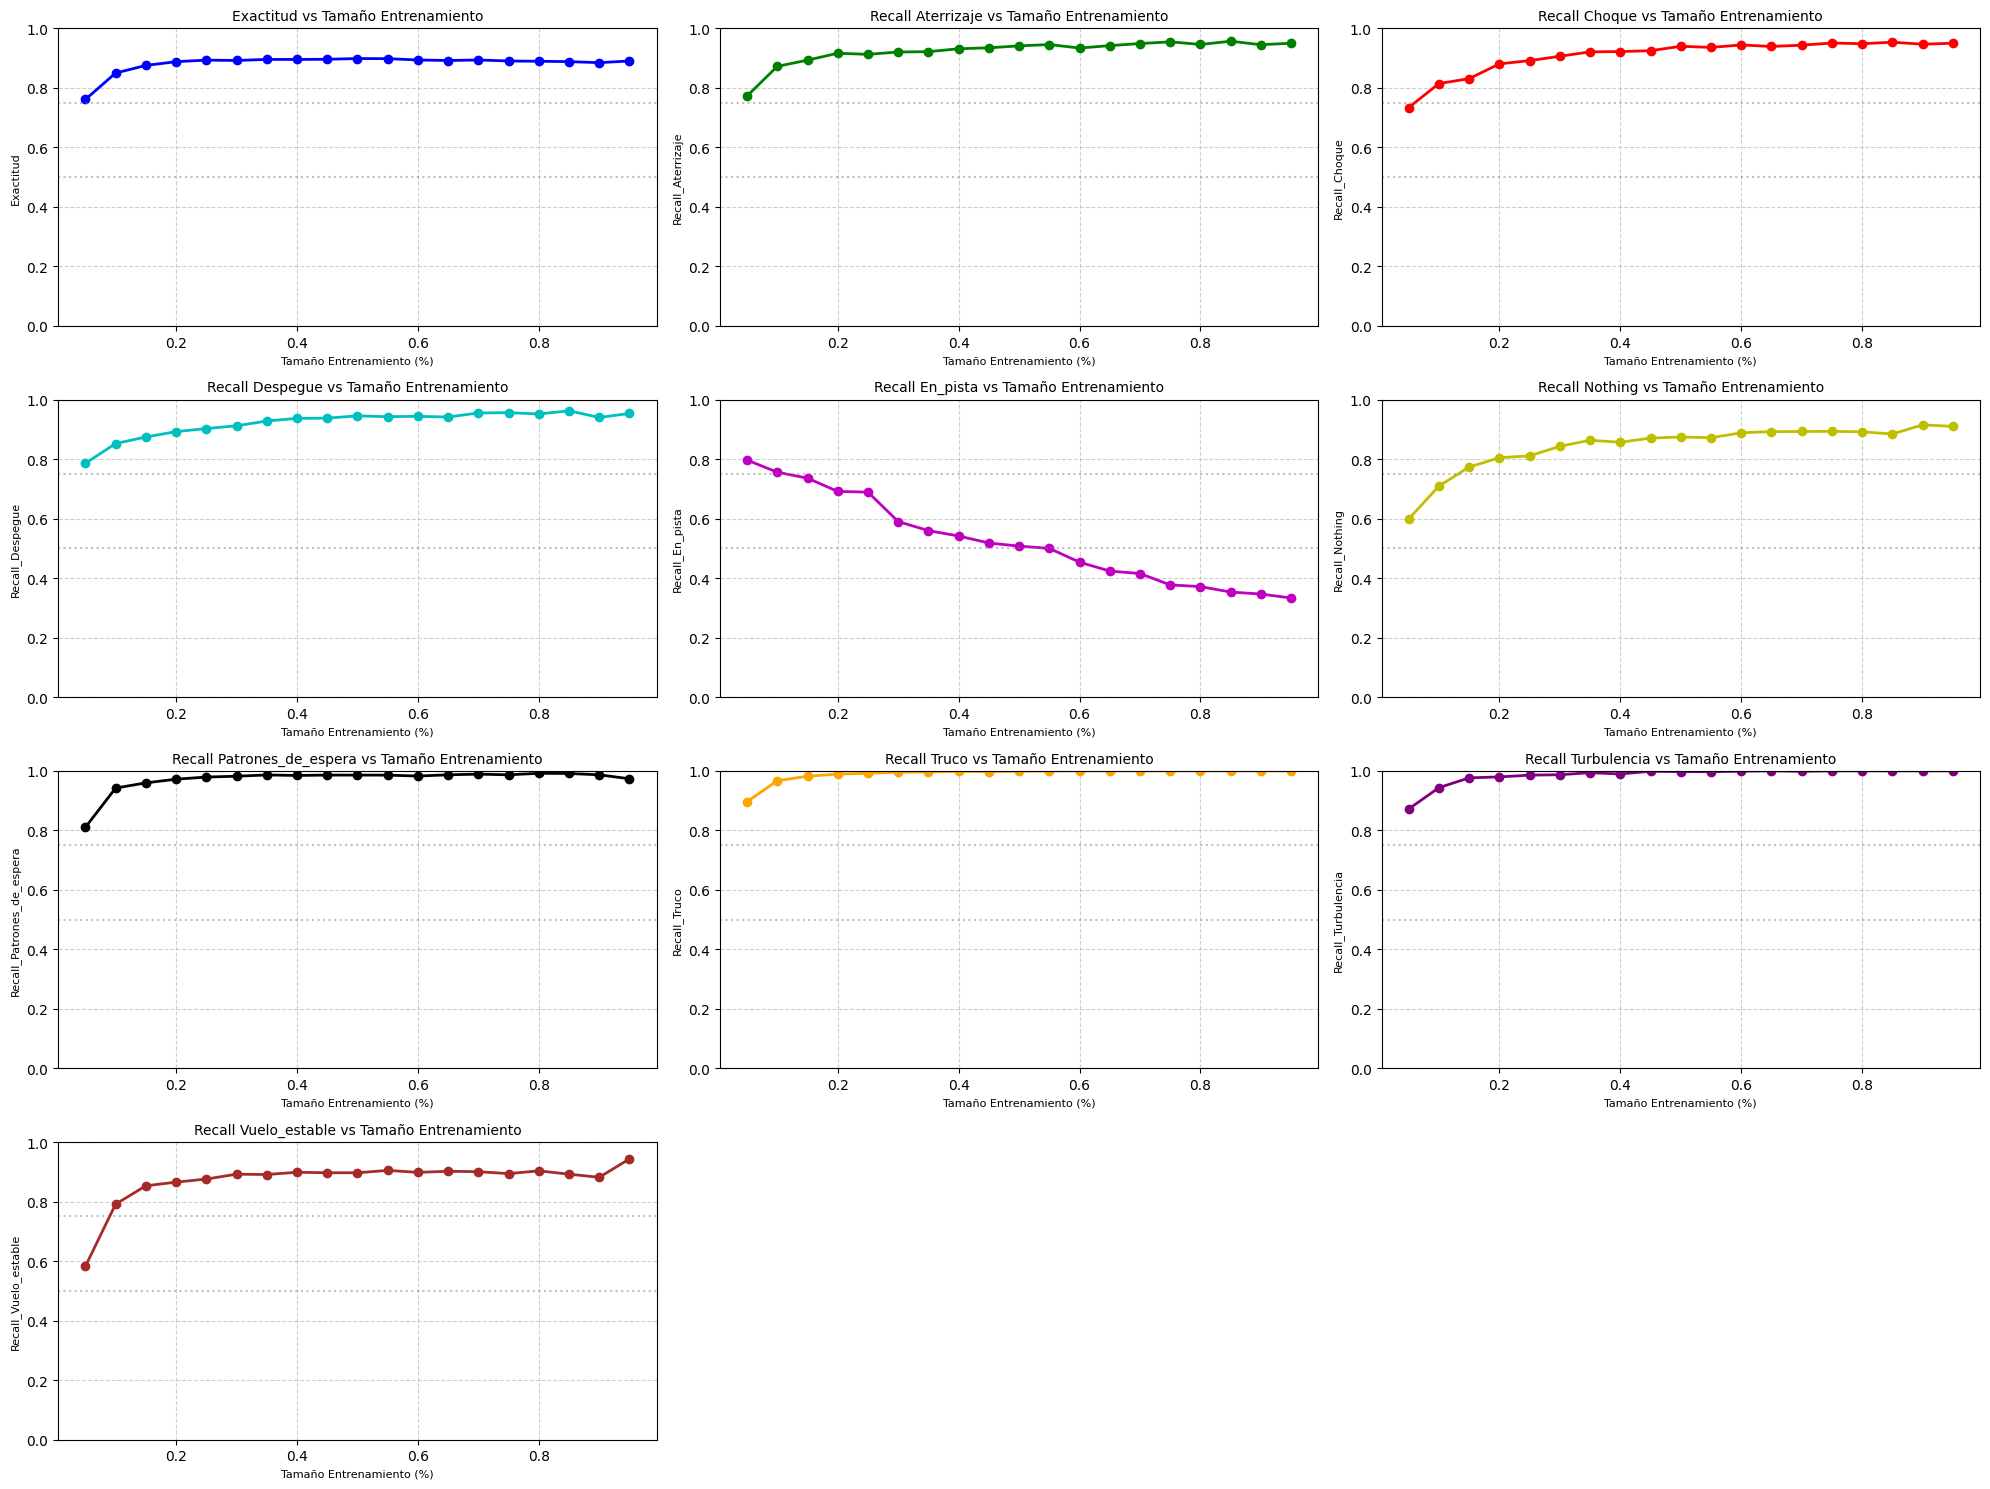

Ejecutando modelo: RandomForestClassifier


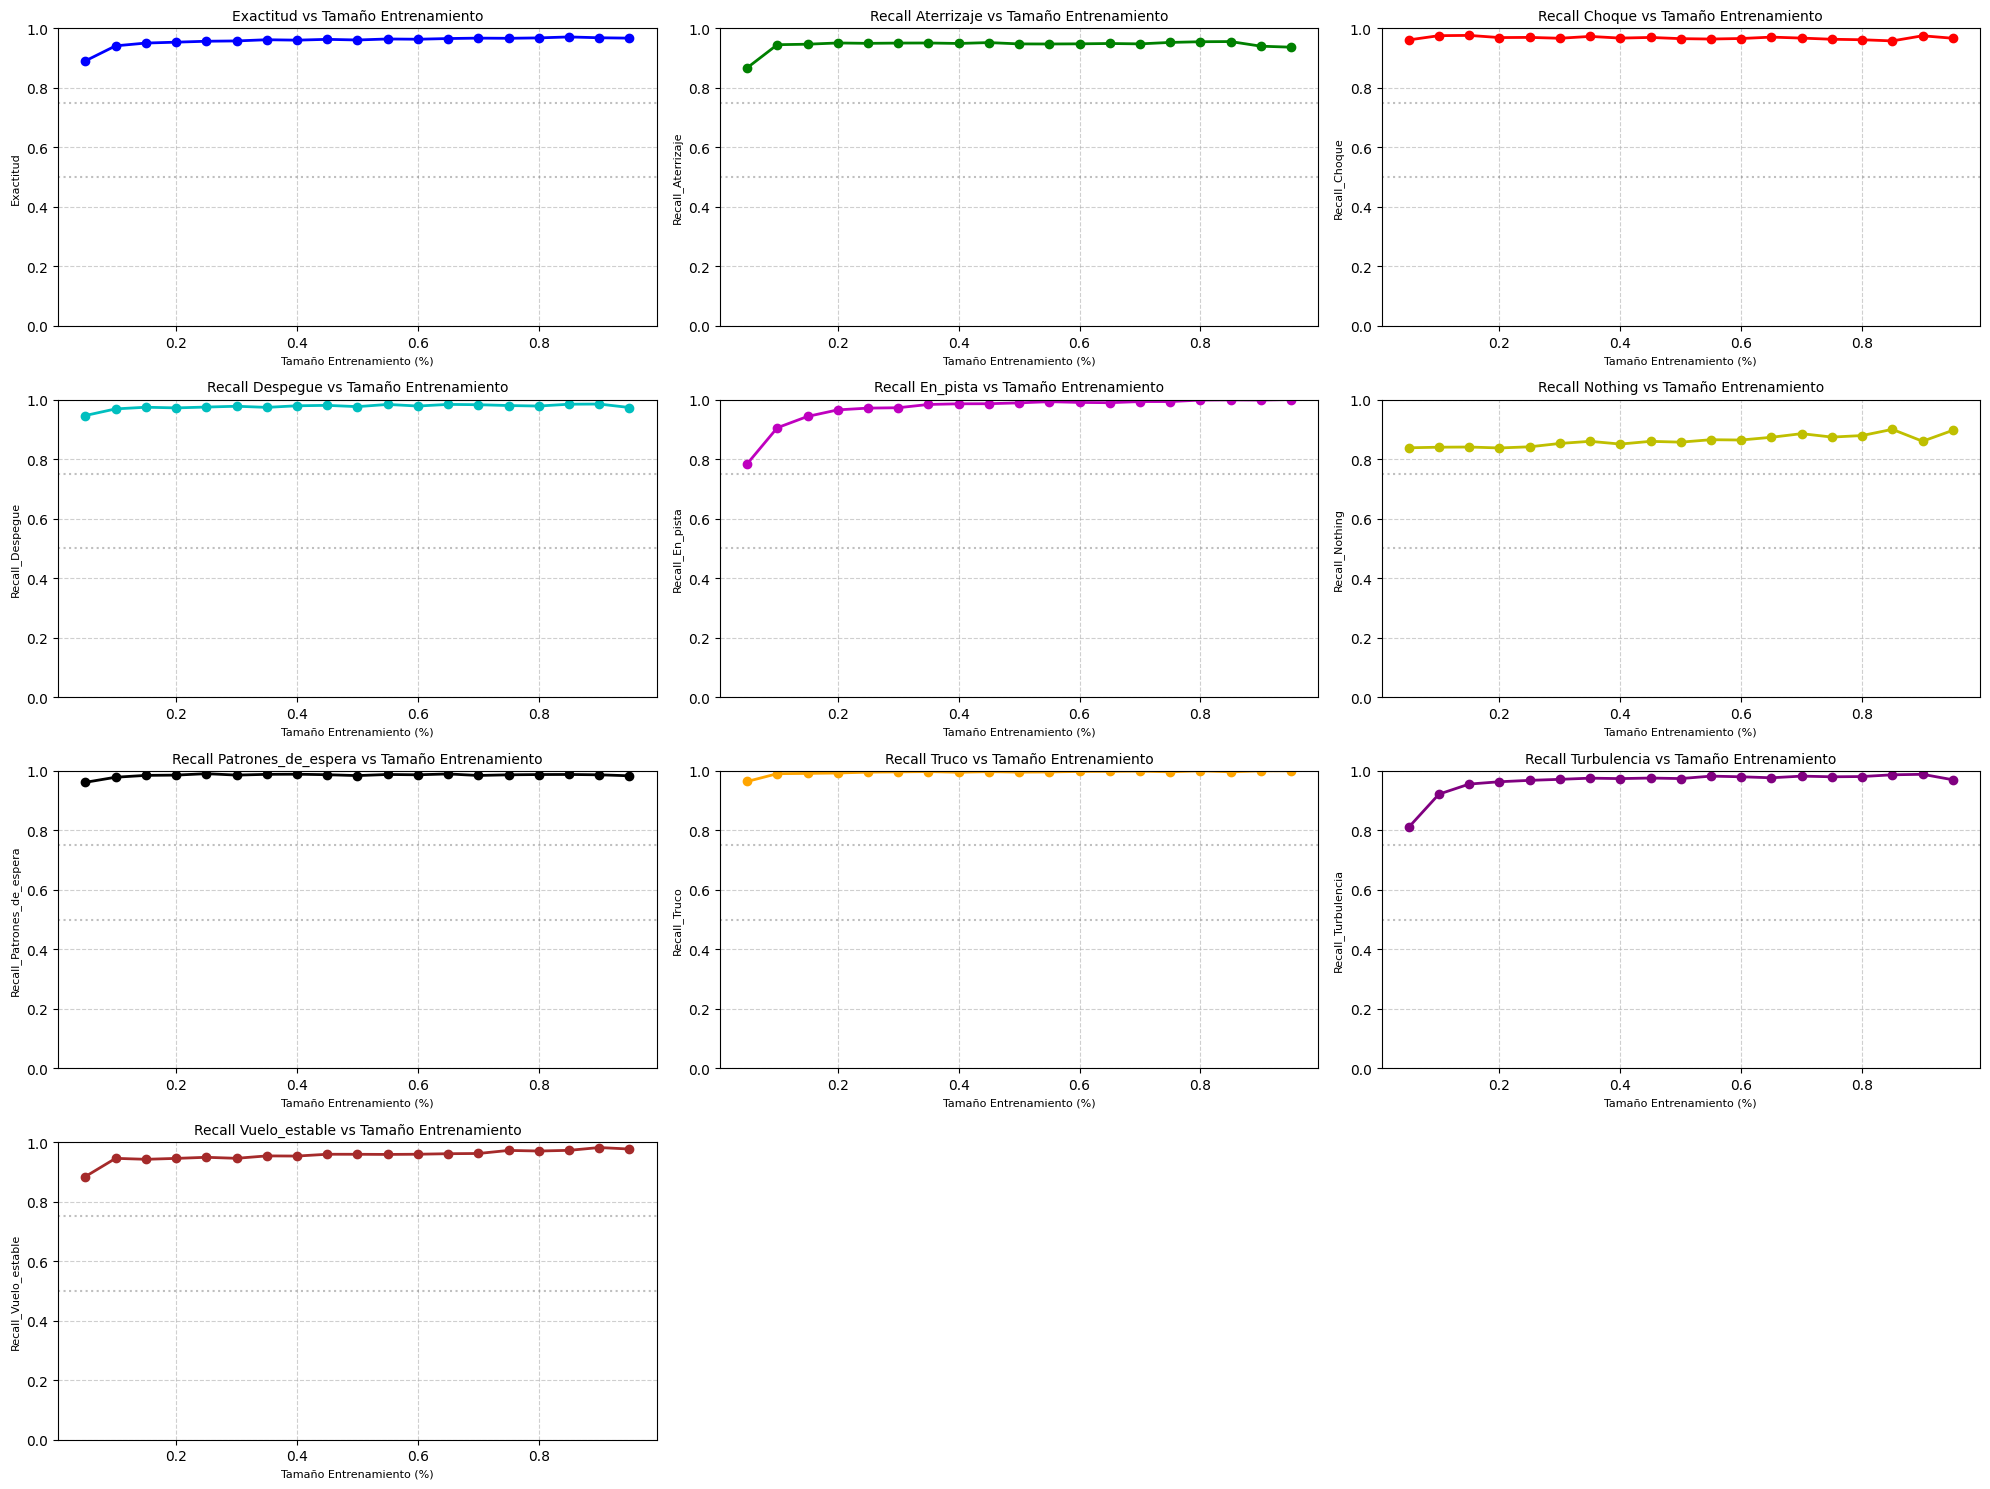

Ejecutando modelo: AdaBoostClassifier


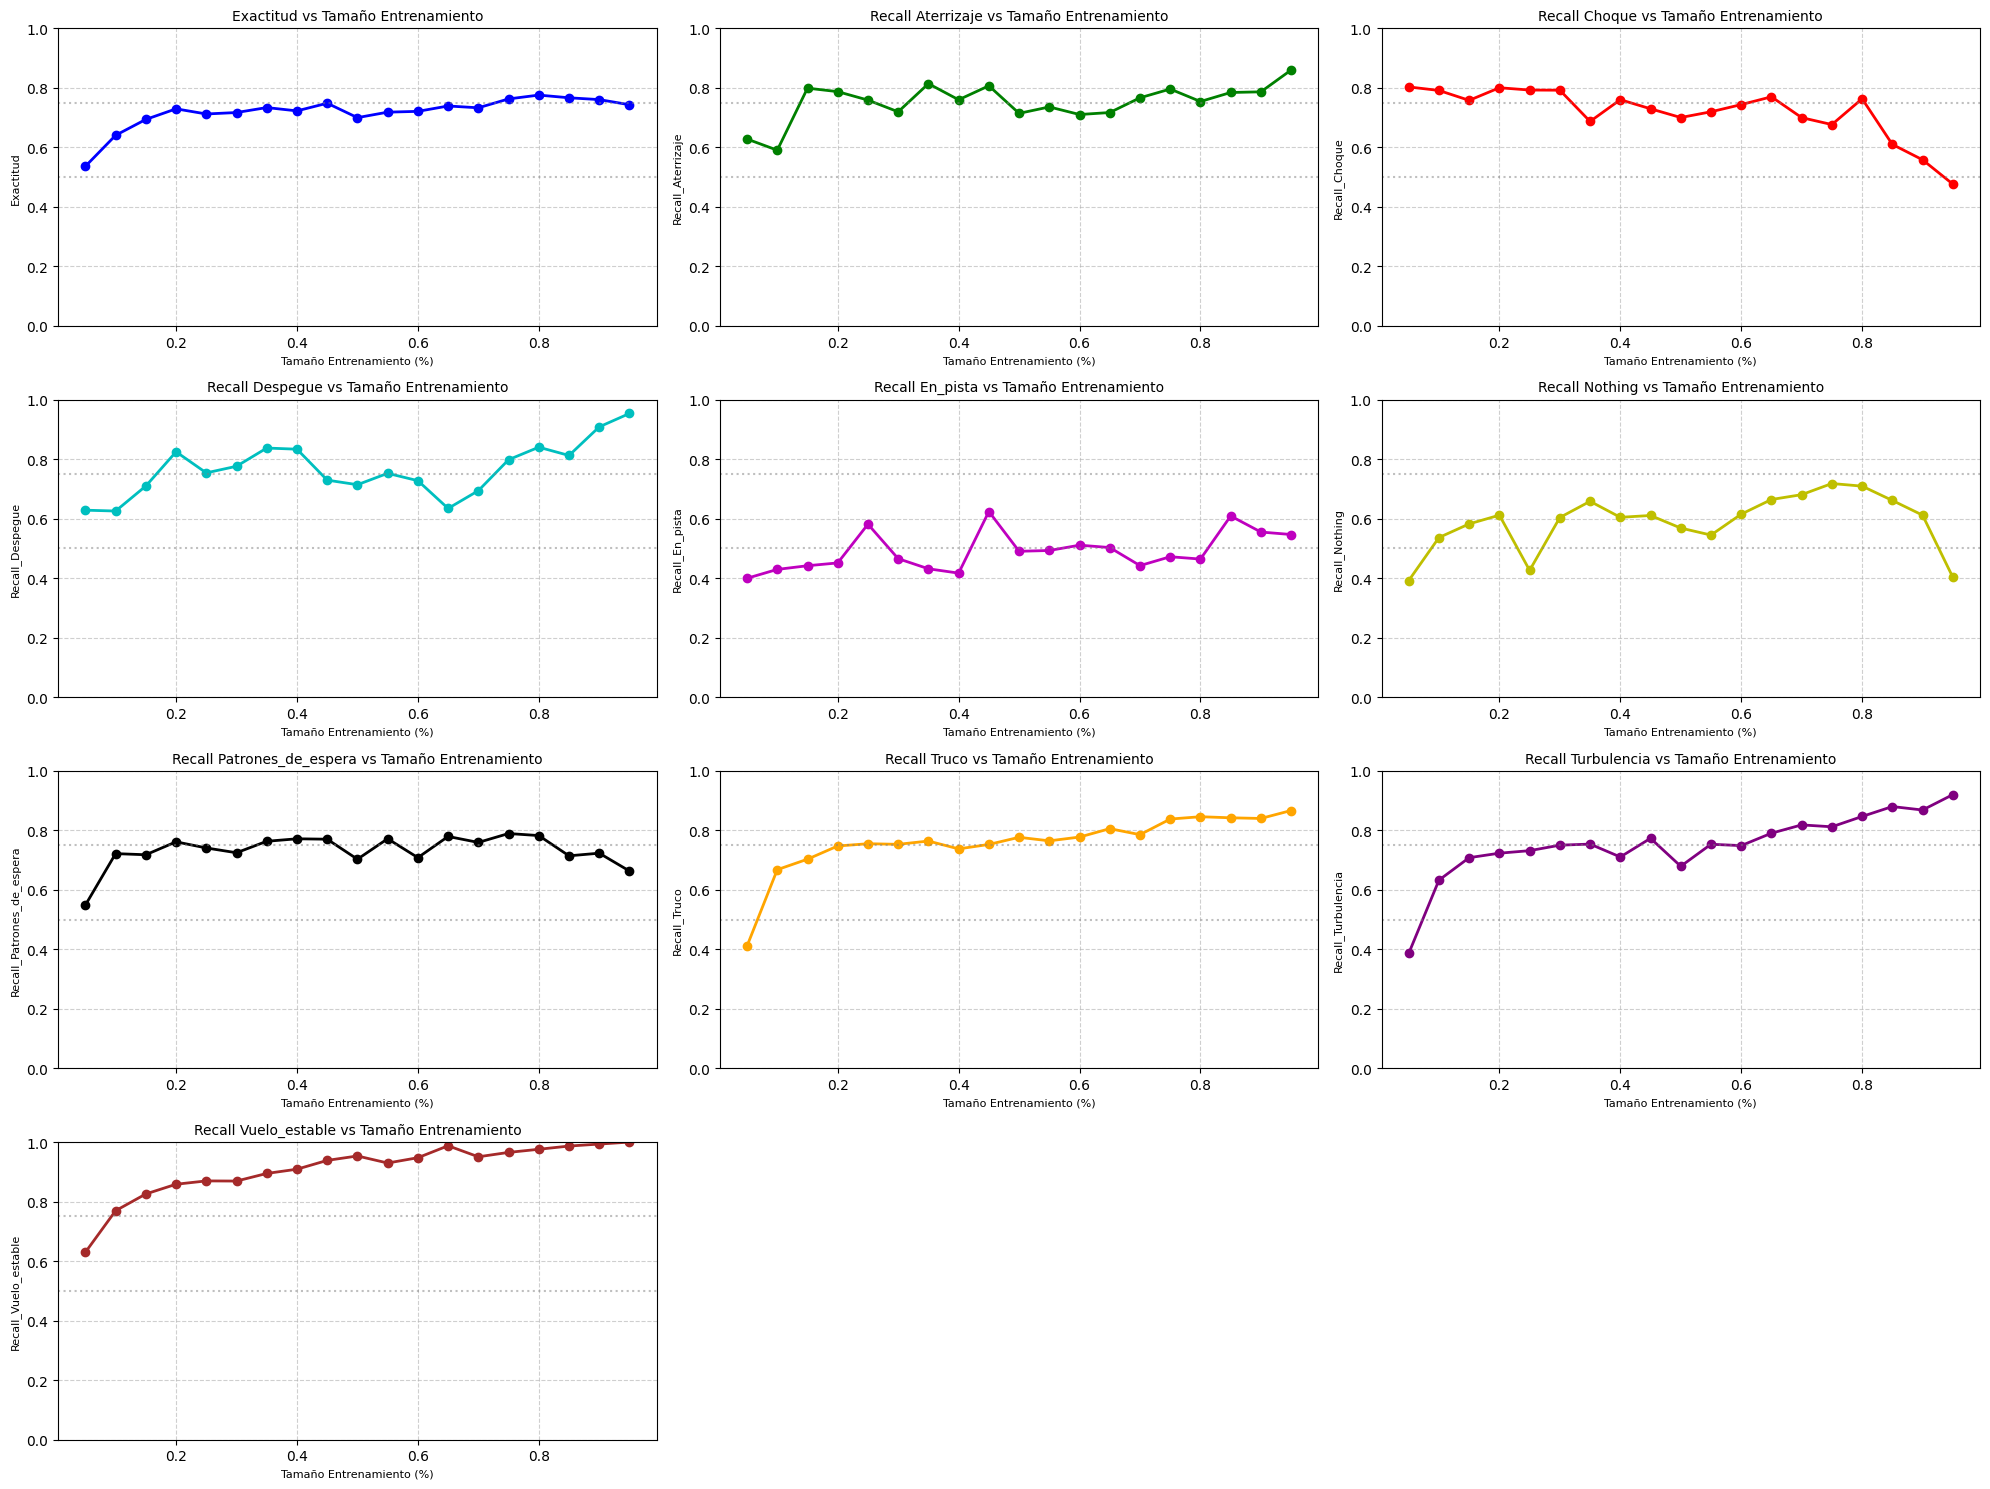

Ejecutando modelo: GradientBoostingClassifier
i: 0, j: 0
i: 0, j: 1
i: 0, j: 2
i: 0, j: 3
i: 0, j: 4
i: 0, j: 5
i: 0, j: 6
i: 0, j: 7
i: 0, j: 8
i: 0, j: 9
i: 0, j: 10
i: 0, j: 11
i: 0, j: 12
i: 0, j: 13
i: 0, j: 14
i: 0, j: 15
i: 0, j: 16
i: 0, j: 17
i: 0, j: 18
i: 0, j: 19
i: 1, j: 0
i: 1, j: 1
i: 1, j: 2
i: 1, j: 3
i: 1, j: 4
i: 1, j: 5
i: 1, j: 6
i: 1, j: 7
i: 1, j: 8
i: 1, j: 9
i: 1, j: 10
i: 1, j: 11
i: 1, j: 12
i: 1, j: 13
i: 1, j: 14
i: 1, j: 15
i: 1, j: 16
i: 1, j: 17
i: 1, j: 18
i: 1, j: 19
i: 2, j: 0
i: 2, j: 1
i: 2, j: 2
i: 2, j: 3
i: 2, j: 4
i: 2, j: 5
i: 2, j: 6
i: 2, j: 7
i: 2, j: 8
i: 2, j: 9
i: 2, j: 10
i: 2, j: 11
i: 2, j: 12
i: 2, j: 13
i: 2, j: 14
i: 2, j: 15
i: 2, j: 16
i: 2, j: 17
i: 2, j: 18
i: 2, j: 19
i: 3, j: 0
i: 3, j: 1
i: 3, j: 2
i: 3, j: 3
i: 3, j: 4
i: 3, j: 5
i: 3, j: 6
i: 3, j: 7
i: 3, j: 8
i: 3, j: 9
i: 3, j: 10
i: 3, j: 11
i: 3, j: 12
i: 3, j: 13
i: 3, j: 14
i: 3, j: 15
i: 3, j: 16
i: 3, j: 17
i: 3, j: 18
i: 3, j: 19
i: 4, j: 0
i: 4, j: 1
i: 4, j: 2
i

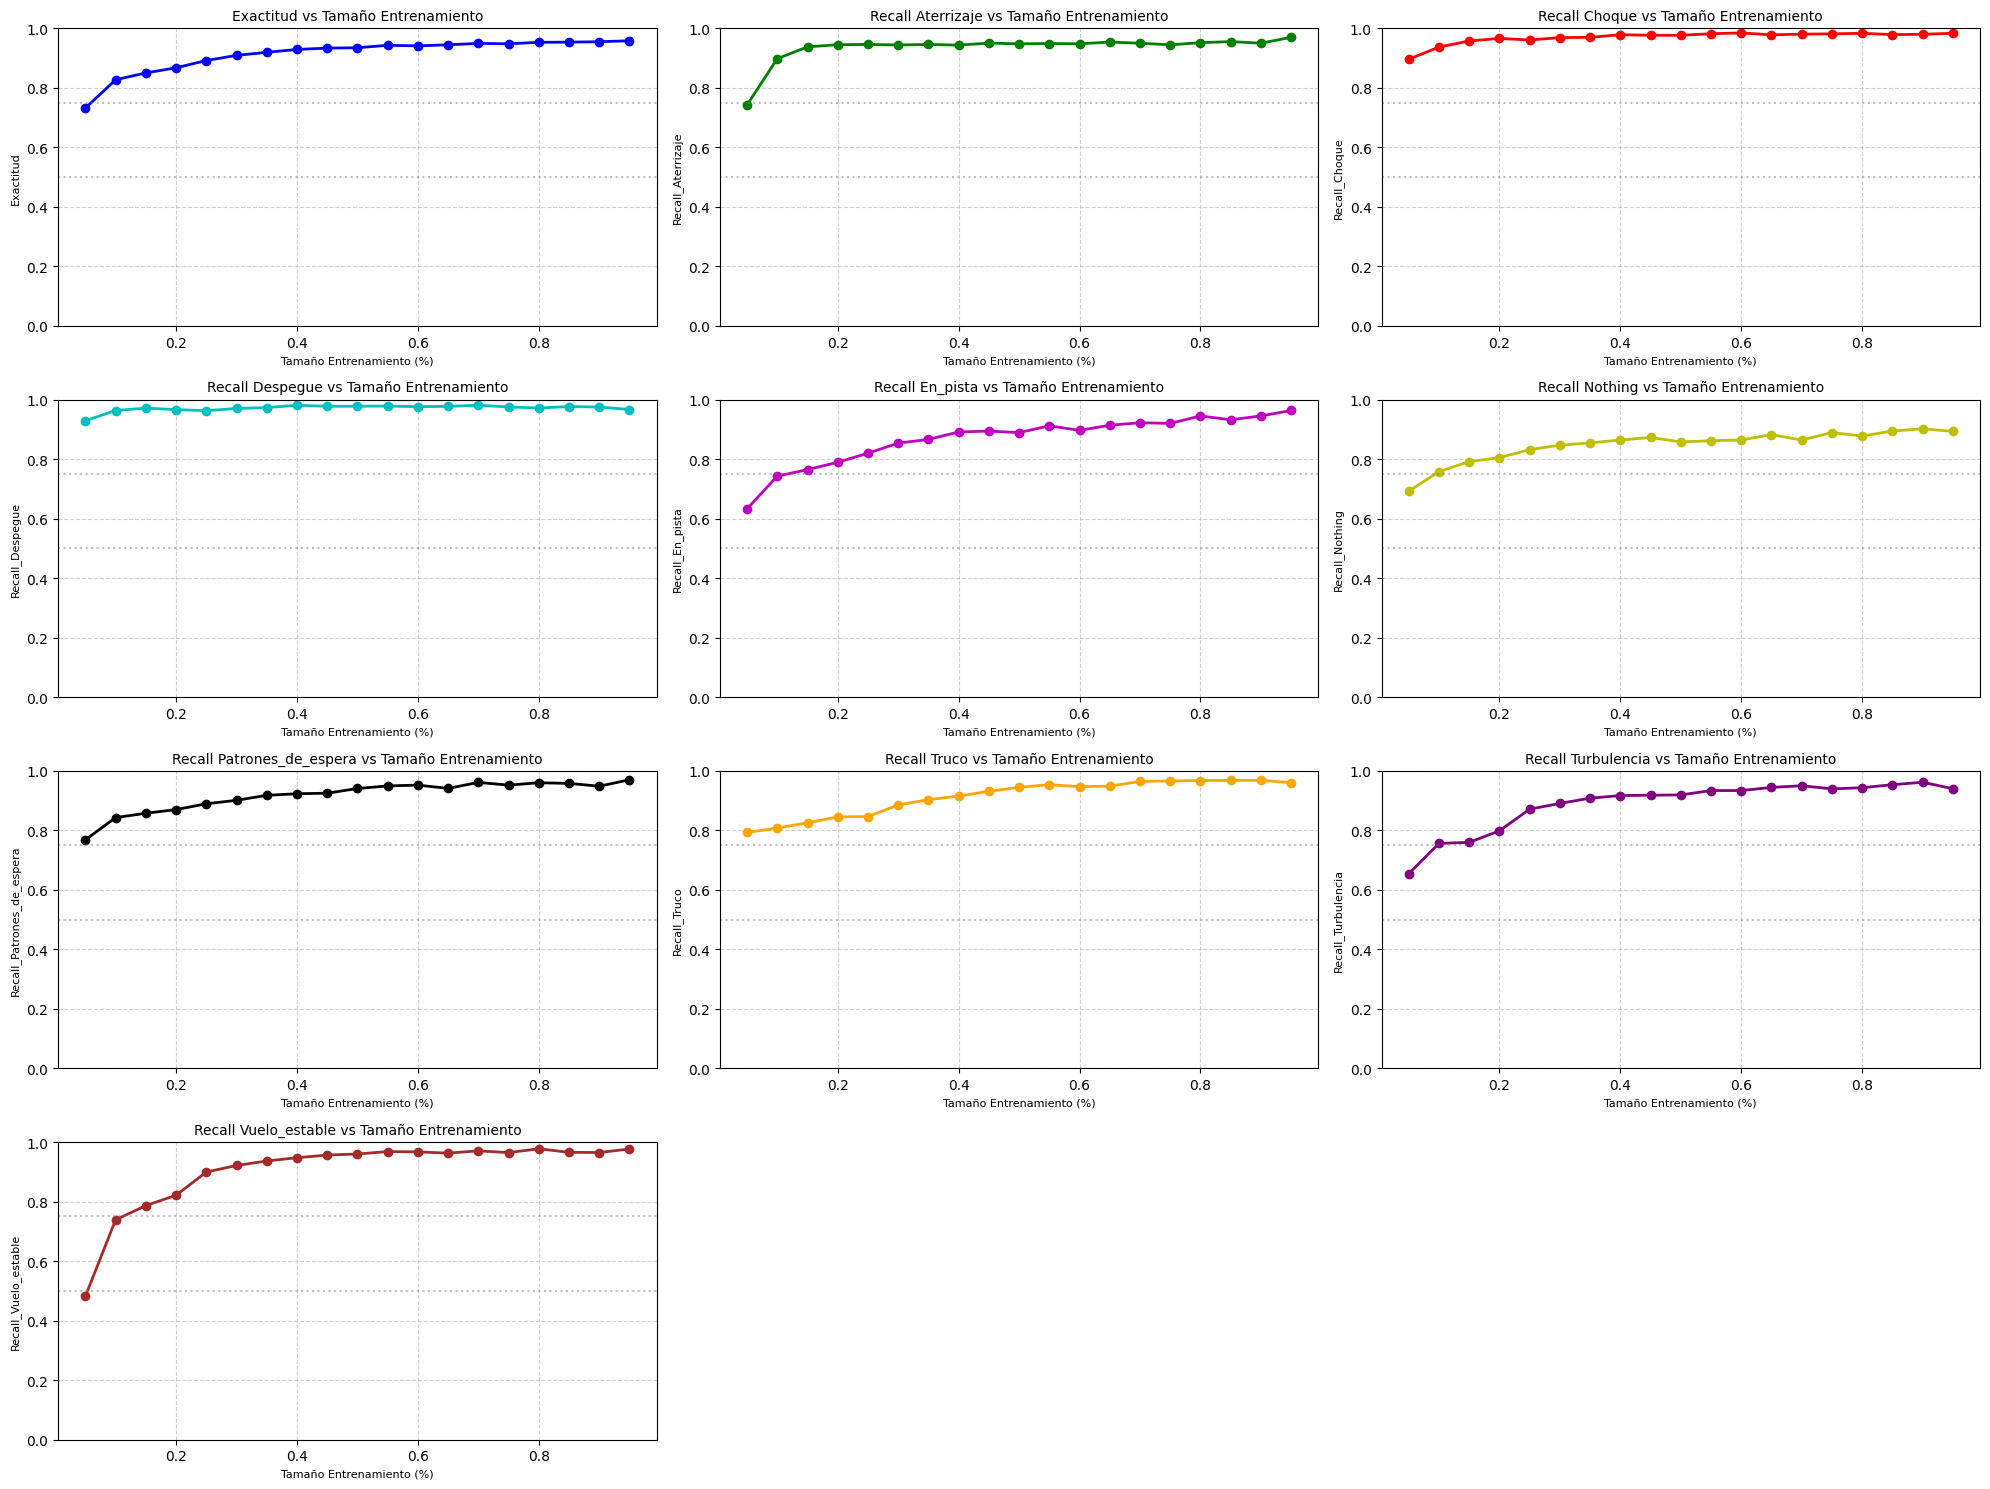

Ejecutando modelo: MLPClassifier
i: 0, j: 0
i: 0, j: 1
i: 0, j: 2
i: 0, j: 3
i: 0, j: 4
i: 0, j: 5
i: 0, j: 6
i: 0, j: 7
i: 0, j: 8
i: 0, j: 9
i: 0, j: 10
i: 0, j: 11
i: 0, j: 12
i: 0, j: 13
i: 0, j: 14
i: 0, j: 15
i: 0, j: 16
i: 0, j: 17
i: 0, j: 18
i: 0, j: 19
i: 1, j: 0
i: 1, j: 1
i: 1, j: 2
i: 1, j: 3
i: 1, j: 4
i: 1, j: 5
i: 1, j: 6
i: 1, j: 7
i: 1, j: 8
i: 1, j: 9
i: 1, j: 10
i: 1, j: 11
i: 1, j: 12
i: 1, j: 13
i: 1, j: 14
i: 1, j: 15
i: 1, j: 16
i: 1, j: 17
i: 1, j: 18
i: 1, j: 19
i: 2, j: 0
i: 2, j: 1
i: 2, j: 2
i: 2, j: 3
i: 2, j: 4
i: 2, j: 5
i: 2, j: 6
i: 2, j: 7
i: 2, j: 8
i: 2, j: 9
i: 2, j: 10
i: 2, j: 11
i: 2, j: 12
i: 2, j: 13
i: 2, j: 14
i: 2, j: 15
i: 2, j: 16
i: 2, j: 17
i: 2, j: 18
i: 2, j: 19
i: 3, j: 0
i: 3, j: 1
i: 3, j: 2
i: 3, j: 3
i: 3, j: 4
i: 3, j: 5
i: 3, j: 6
i: 3, j: 7
i: 3, j: 8
i: 3, j: 9
i: 3, j: 10
i: 3, j: 11
i: 3, j: 12
i: 3, j: 13
i: 3, j: 14
i: 3, j: 15
i: 3, j: 16
i: 3, j: 17
i: 3, j: 18
i: 3, j: 19
i: 4, j: 0
i: 4, j: 1
i: 4, j: 2
i: 4, j: 3
i: 

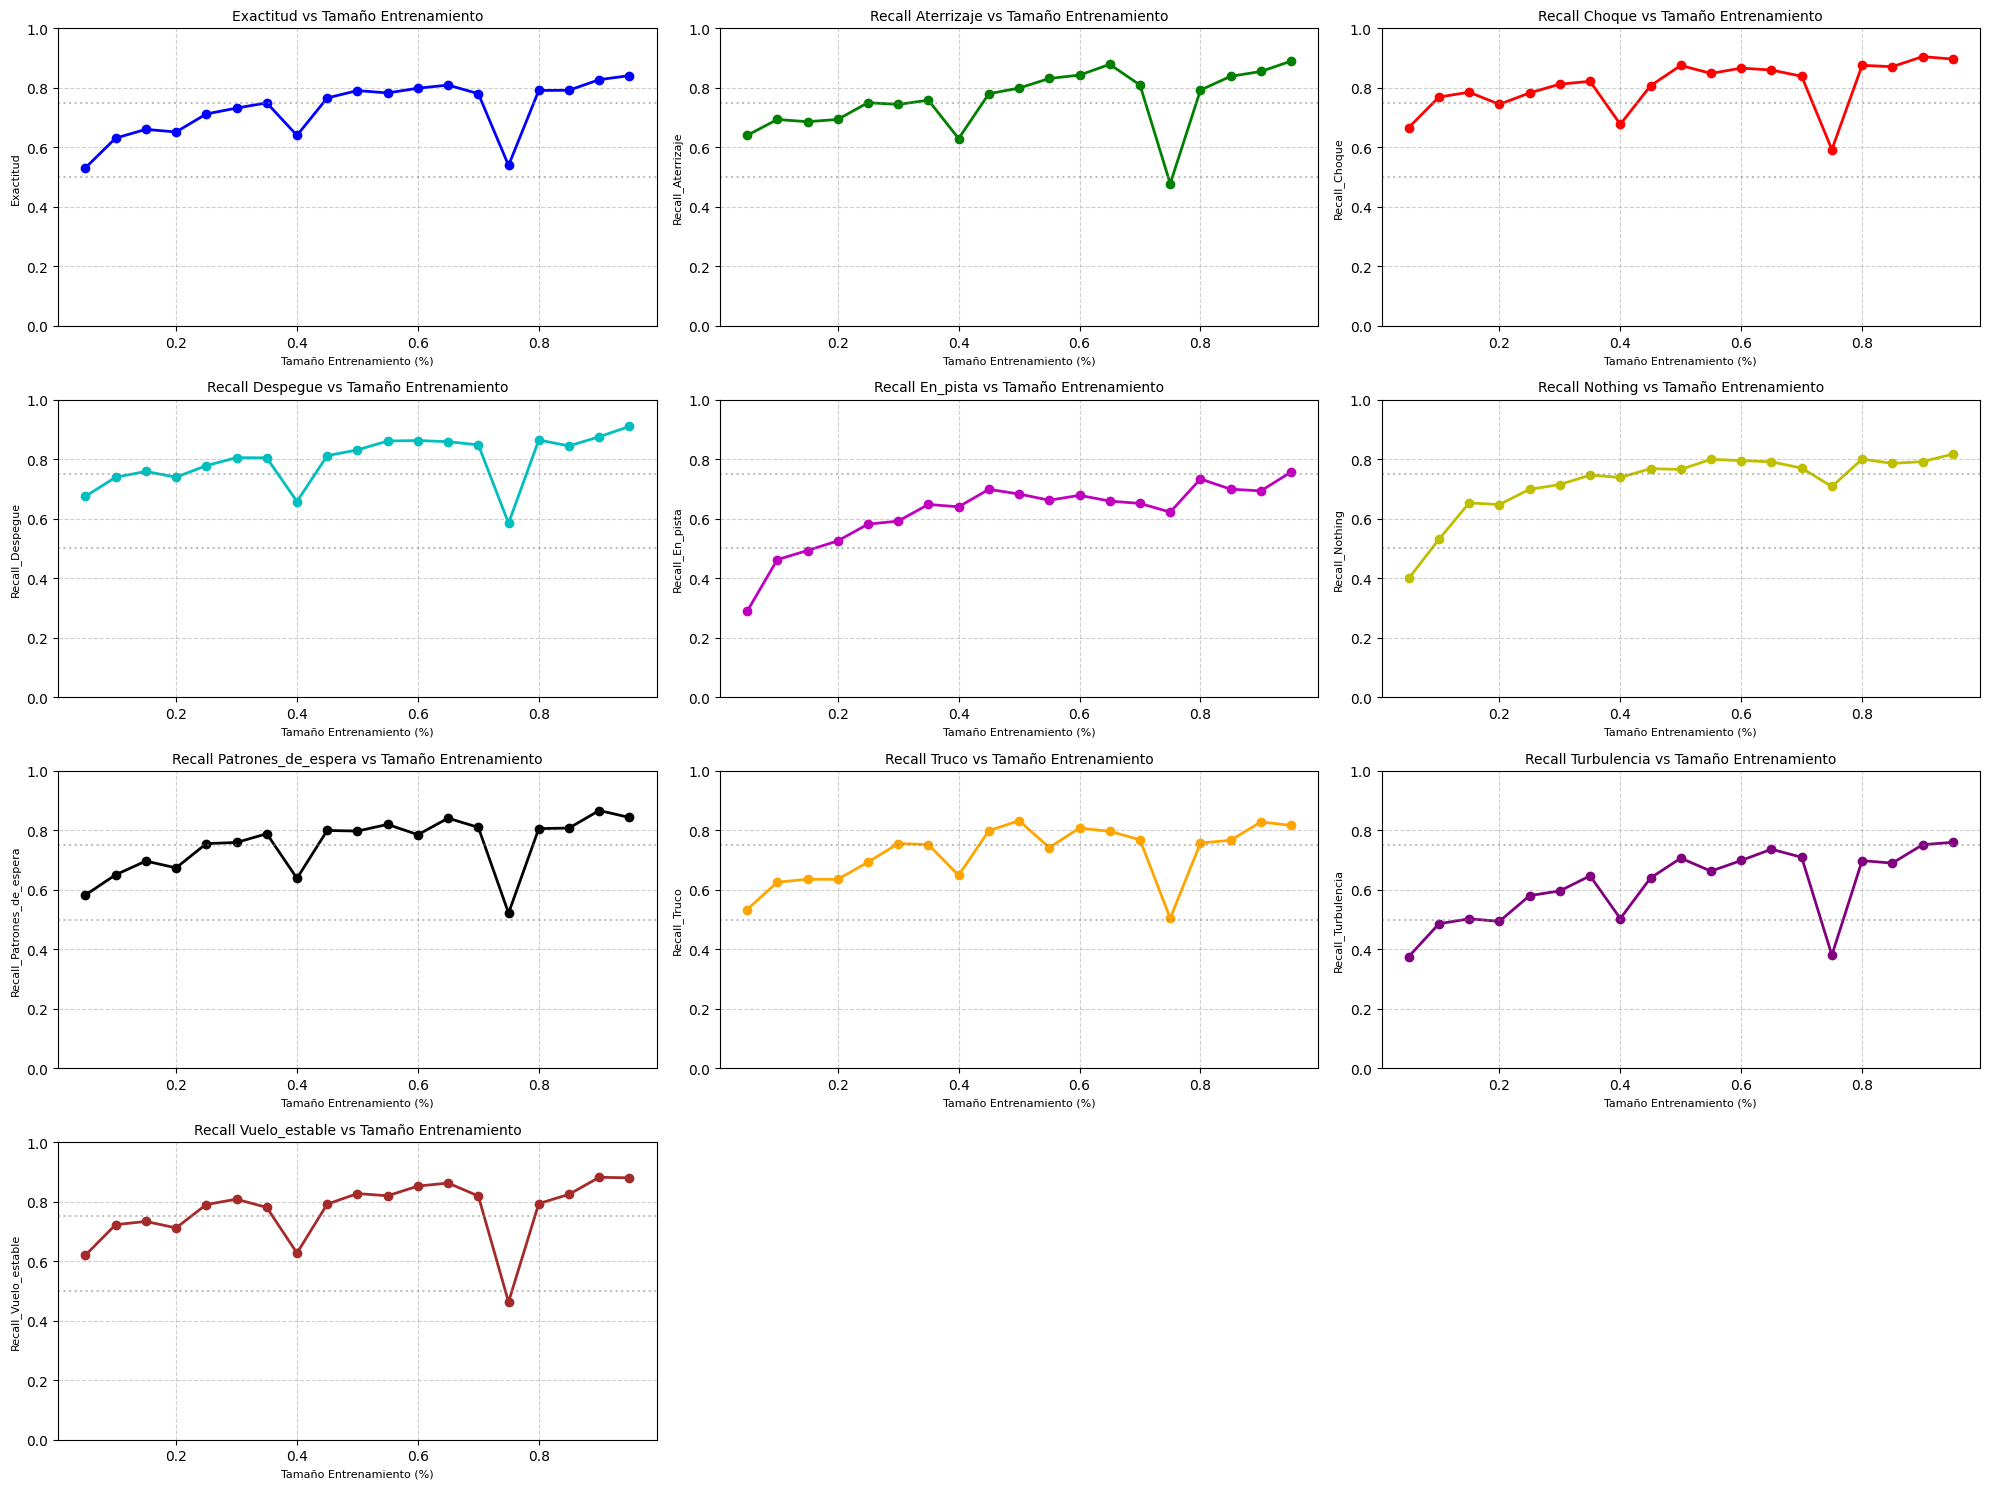

Ejecutando modelo: SVC_linear
i: 0, j: 0
i: 0, j: 1
i: 0, j: 2
i: 0, j: 3
i: 0, j: 4
i: 0, j: 5
i: 0, j: 6
i: 0, j: 7
i: 0, j: 8
i: 0, j: 9
i: 0, j: 10
i: 0, j: 11
i: 0, j: 12
i: 0, j: 13
i: 0, j: 14
i: 0, j: 15
i: 0, j: 16
i: 0, j: 17
i: 0, j: 18
i: 0, j: 19
i: 1, j: 0
i: 1, j: 1
i: 1, j: 2
i: 1, j: 3
i: 1, j: 4
i: 1, j: 5
i: 1, j: 6
i: 1, j: 7
i: 1, j: 8
i: 1, j: 9
i: 1, j: 10
i: 1, j: 11
i: 1, j: 12
i: 1, j: 13
i: 1, j: 14
i: 1, j: 15
i: 1, j: 16
i: 1, j: 17
i: 1, j: 18
i: 1, j: 19
i: 2, j: 0
i: 2, j: 1
i: 2, j: 2
i: 2, j: 3
i: 2, j: 4
i: 2, j: 5
i: 2, j: 6
i: 2, j: 7
i: 2, j: 8
i: 2, j: 9
i: 2, j: 10
i: 2, j: 11
i: 2, j: 12
i: 2, j: 13
i: 2, j: 14
i: 2, j: 15
i: 2, j: 16
i: 2, j: 17
i: 2, j: 18
i: 2, j: 19
i: 3, j: 0
i: 3, j: 1
i: 3, j: 2
i: 3, j: 3
i: 3, j: 4
i: 3, j: 5
i: 3, j: 6
i: 3, j: 7
i: 3, j: 8
i: 3, j: 9
i: 3, j: 10
i: 3, j: 11
i: 3, j: 12
i: 3, j: 13
i: 3, j: 14
i: 3, j: 15
i: 3, j: 16
i: 3, j: 17
i: 3, j: 18
i: 3, j: 19
i: 4, j: 0
i: 4, j: 1
i: 4, j: 2
i: 4, j: 3
i: 4, 

In [ ]:
#40 minutos aprox SIN considerar el asqueroso SVC_linear
for modelo in modelos_kernel:
    print(f"Ejecutando modelo: {modelo}")

    prueba_tamano_entrenamiento(x, y, modelo)

# Optimización de los Modelos Seleccionados

1. Seleccione dos de los modelos probados en el paso anterior que tengan hiperparámetros, e indique cuáles son dichos hiperparámetros.

---

Se seleccionaron los modelos de `GradientBoostingClassifier` y `RandomForestClassifier` ya que tuvieron la exactitud más alta y mejores recalls por clase. Sus hiperparámetros están .
El parámetro que se busca optimizar es la profundidad máxima.

2. Seleccione al menos uno de los hiperparámetros de cada modelo, y grafique el rendimiento que se obtendría con distintos valores propuestos para cada modelo.

Para Random Forest

In [ ]:
mm = np.arange(1,20)

acc1 = []

for m in mm:
    
    acc_cv1 = []

    sss = StratifiedShuffleSplit(
        n_splits=5,
        train_size=0.8,
        random_state=1234
    ) 

    for train_index, test_index in sss.split(x, y):
    
        # Training phase
        x_train1 = x[train_index, :]
        y_train1 = y[train_index]     

        clf_cv1 = RandomForestClassifier(max_depth=m, random_state=1234)           

        clf_cv1.fit(x_train1, y_train1)

        # Test phase
        x_test1 = x[test_index, :]
        y_test1 = y[test_index]
        y_pred1 = clf_cv1.predict(x_test1)    
        
        acc_i1 = accuracy_score(y_test1, y_pred1)
        acc_cv1.append(acc_i1)    

    acc_hyp1 = np.average(acc_cv1)
    acc1.append(acc_hyp1)

opt_index1 = np.argmax(acc1)
opt_hyperparameter1 = mm[opt_index1]
opt_acc1 = acc1[opt_index1]

print("m óptimo: ", opt_hyperparameter1)
print("Its accuracy: ", opt_acc1)
plt.plot(mm, acc1)
plt.xlabel("m")
plt.ylabel("Accuracy")

plt.show()

para Gradient Boosting

In [ ]:
mm = np.arange(1,40)

acc2 = []

for m in mm:
    
    acc_cv2 = []

    sss = StratifiedShuffleSplit(
        n_splits=5,
        train_size=0.8,
        random_state=1234
    ) 

    for train_index, test_index in sss.split(x, y):
    
        # Training phase
        x_train2 = x[train_index, :]
        y_train2 = y[train_index]     

        clf_cv2 = GradientBoostingClassifier(max_depth=m, random_state=1234)           

        clf_cv2.fit(x_train2, y_train2)

        # Test phase
        x_test2 = x[test_index, :]
        y_test2 = y[test_index]
        y_pred2 = clf_cv2.predict(x_test2)    
        
        acc_i2 = accuracy_score(y_test2, y_pred2)
        acc_cv2.append(acc_i2)    

    acc_hyp2 = np.average(acc_cv2)
    acc2.append(acc_hyp2)

opt_index2 = np.argmax(acc2)
opt_hyperparameter2 = mm[opt_index2]
opt_acc2 = acc2[opt_index2]

print("m óptimo: ", opt_hyperparameter2)
print("Its accuracy: ", opt_acc2)
plt.plot(mm, acc2)
plt.xlabel("m")
plt.ylabel("Accuracy")

plt.show()

3. Para los mismos modelos de clasificación, aplique algún método de selección de características, e indique cuáles son las características seleccionadas. ¿Es posible reducir el número de características sin perder rendimiento en su modelo?

Random Forest

In [ ]:
n_feats = np.arange(1,86)

acc_nfeat1 = []

for n_feat in n_feats:
    
    acc_cv1 = []

    sss = StratifiedShuffleSplit(
        n_splits=5,
        train_size=0.8,
        random_state=1234
    ) 

    for train_index, test_index in sss.split(x, y):
    
        # Training phase
        x_train1 = x[train_index, :]
        y_train1 = y[train_index]     

        clf_cv1 = RandomForestClassifier(max_depth=opt_hyperparameter1, random_state=1234)

        fselection_cv1 = RFE(clf_cv1, n_features_to_select=n_feat)
        fselection_cv1.fit(x_train1, y_train1)
        x_train1 = fselection_cv1.transform(x_train1)

        clf_cv1.fit(x_train1, y_train1)

        # Test phase
        x_test1 = fselection_cv1.transform(x[test_index, :])
        y_test1 = y[test_index]
        y_pred1 = clf_cv1.predict(x_test1)

        acc_i1 = accuracy_score(y_test1, y_pred1)
        acc_cv1.append(acc_i1)    

    acc1 = np.average(acc_cv1)
    acc_nfeat1.append(acc1)

opt_index1 = np.argmax(acc_nfeat1)
opt_features1 = n_feats[opt_index1]
opt_acc1 = acc_nfeat1[opt_index1]
print("Optimal number of features: ", opt_features1)
print("Its accuracy: ", opt_acc1)

plt.plot(n_feats, acc_nfeat1)
plt.xlabel("Features")
plt.ylabel("Accuracy")

plt.show()

# Fit model with optimal number of features
clf = RandomForestClassifier(max_depth=opt_hyperparameter1, random_state=1234)
fselection1 = RFE(clf, n_features_to_select=n_feat)
fselection1.fit(x, y)

print("Selected features: ", fselection1.get_feature_names_out())


Gradient Boosting

In [ ]:
n_feats = np.arange(1,60)

acc_nfeat2 = []

for n_feat in n_feats:
    
    acc_cv2 = []

    sss = StratifiedShuffleSplit(
        n_splits=5,
        train_size=0.8,
        random_state=1234
    ) 

    for train_index, test_index in sss.split(x, y):
    
        # Training phase
        x_train2 = x[train_index, :]
        y_train2 = y[train_index]     

        clf_cv2 = GradientBoostingClassifier(max_depth=opt_hyperparameter2, random_state=1234)

        fselection_cv2 = RFE(clf_cv2, n_features_to_select=n_feat)
        fselection_cv2.fit(x_train2, y_train2)
        x_train2 = fselection_cv2.transform(x_train2)

        clf_cv2.fit(x_train2, y_train2)

        # Test phase
        x_test2 = fselection_cv2.transform(x[test_index, :])
        y_test2 = y[test_index]
        y_pred2 = clf_cv2.predict(x_test2)

        acc_i2 = accuracy_score(y_test2, y_pred2)
        acc_cv2.append(acc_i2)    

    acc2 = np.average(acc_cv2)
    acc_nfeat2.append(acc2)

opt_index2 = np.argmax(acc_nfeat2)
opt_features2 = n_feats[opt_index2]
opt_acc2 = acc_nfeat2[opt_index2]
print("Optimal number of features: ", opt_features2)
print("Its accuracy: ", opt_acc2)

plt.plot(n_feats, acc_nfeat2)
plt.xlabel("Features")
plt.ylabel("Accuracy")

plt.show()

# Fit model with optimal number of features
clf = GradientBoostingClassifier(max_depth=opt_hyperparameter2, random_state=1234)
fselection2 = RFE(clf, n_features_to_select=n_feat)
fselection2.fit(x, y)

print("Selected features: ", fselection2.get_feature_names_out())

---

4. Evalúe sus modelos de clasificación optimizando hiperparámetros y llevando a cabo selección de características con validación cruzada anidada.

Random Forest

In [ ]:
mm = np.arange(1,20)
acc = []

n_feats = np.arange(1,20)

#Optimización de hiperparámeros 
for m in mm:
    
    acc_hyper=[]

    #Reducción de características
    for n_feat in n_feats:
        
        acc_cv = []

        sss = StratifiedShuffleSplit(
            n_splits=5,
            train_size=0.8,
            random_state=1234
        ) 

        for train_index, test_index in sss.split(x, y):
        
            # Training phase
            x_train = x[train_index, :]
            y_train = y[train_index]     

            clf_cv = RandomForestClassifier(max_depth=m, random_state=1234)

            fselection_cv = 3(clf_cv, n_features_to_select=n_feat)
            fselection_cv.fit(x_train, y_train)
            x_train = fselection_cv.transform(x_train)

            clf_cv.fit(x_train, y_train)

            # Test phase
            x_test = fselection_cv.transform(x[test_index, :])
            y_test = y[test_index]
            y_pred = clf_cv.predict(x_test)

            acc_i = accuracy_score(y_test, y_pred)
            acc_cv.append(acc_i)    

        acc_feats = np.average(acc_cv)
        acc_hyper.append(acc_feats)
    
    acc.append(acc_hyper)

opt_acc=[]
opt_indexes=[]
for item in acc:
    item=np.array(item)
    opt_indexes.append(np.argmax(item))
    opt_acc.append(np.max(item))
opt_hype_index=np.argmax(opt_acc)
opt_feat_index=opt_indexes[opt_hype_index]

opt_features = n_feats[opt_feat_index]
opt_hyperparameter = mm[opt_hype_index]
opt_acc = opt_acc[opt_hype_index]
print("Optimal number of hyperparameters: ", opt_hyperparameter)
print("Optimal number of features: ", opt_features)
print("Its accuracy: ", opt_acc)

"""plt.plot(n_feats, acc_nfeat)
plt.xlabel("Features")
plt.ylabel("Accuracy")

plt.show()"""

# Fit model with optimal number of features
clf = RandomForestClassifier(max_depth=opt_hyperparameter, random_state=1234)
fselection = RFE(clf_cv, n_features_to_select=n_feat)
fselection.fit(x, y)

print("Selected features: ", fselection.get_feature_names_out())


Gradient Boosting

In [ ]:
mm = np.arange(1,40)
acc = []

n_feats = np.arange(1,40)

#Optimización de hiperparámeros 
for m in mm:
    
    acc_hyper=[]

    #Reducción de características
    for n_feat in n_feats:
        
        acc_cv = []

        sss = StratifiedShuffleSplit(
            n_splits=5,
            train_size=0.8,
            random_state=1234
        ) 

        for train_index, test_index in sss.split(x, y):
        
            # Training phase
            x_train = x[train_index, :]
            y_train = y[train_index]     

            clf_cv = GradientBoostingClassifier(max_depth=m, random_state=1234)

            fselection_cv = RFE(clf_cv, n_features_to_select=n_feat)
            fselection_cv.fit(x_train, y_train)
            x_train = fselection_cv.transform(x_train)

            clf_cv.fit(x_train, y_train)

            # Test phase
            x_test = fselection_cv.transform(x[test_index, :])
            y_test = y[test_index]
            y_pred = clf_cv.predict(x_test)

            acc_i = accuracy_score(y_test, y_pred)
            acc_cv.append(acc_i)    

        acc_feats = np.average(acc_cv)
        acc_hyper.append(acc_feats)
    
    acc.append(acc_hyper)

opt_acc=[]
opt_indexes=[]
for item in acc:
    item=np.array(item)
    opt_indexes.append(np.argmax(item))
    opt_acc.append(np.max(item))
opt_hype_index=np.argmax(opt_acc)
opt_feat_index=opt_indexes[opt_hype_index]

opt_features = n_feats[opt_feat_index]
opt_hyperparameter = mm[opt_hype_index]
opt_acc = opt_acc[opt_hype_index]
print("Optimal number of hyperparameters: ", opt_hyperparameter)
print("Optimal number of features: ", opt_features)
print("Its accuracy: ", opt_acc)

"""plt.plot(n_feats, acc_nfeat)
plt.xlabel("Features")
plt.ylabel("Accuracy")

plt.show()"""

# Fit model with optimal number of features
clf = RandomForestClassifier(max_depth=opt_hyperparameter, random_state=1234)
fselection = RFE(clf_cv, n_features_to_select=n_feat)
fselection.fit(x, y)

print("Selected features: ", fselection.get_feature_names_out())
